In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
plt.style.use('default')

# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image,compute_radial_spectrum
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params,Inference_pipeline,compute_SNR_grid,plot_likelihood,get_conf_intervals,Spectra_Loss,compute_Loss_grid
from GRF_perturbations.Modules.GRF_generation import get_k_grid,nonsingular_Power_spectrum

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


In [3]:
noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

# Gamma distributions

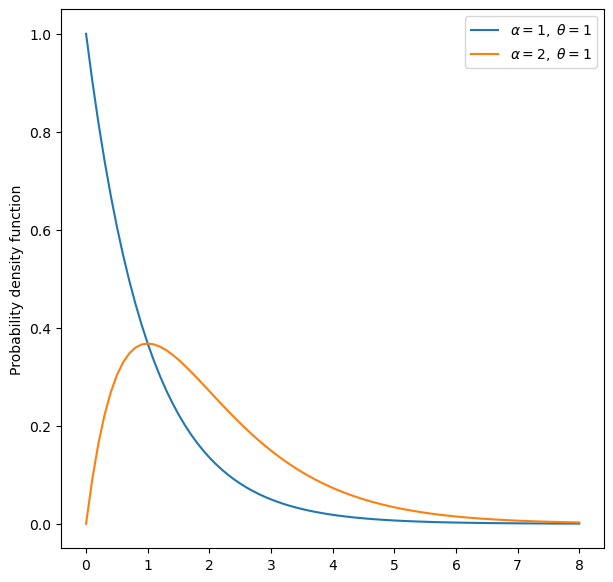

In [4]:
from scipy.stats import gamma,lognorm
plt.figure(figsize=(7,7))
x=np.linspace(0,8,81)

plt.plot(x,gamma.pdf(x,1,0,1),label=r'$\alpha=1, \ \theta=1$')
plt.plot(x,gamma.pdf(x,2,0,1),label=r'$\alpha=2, \ \theta=1$')
plt.legend()
plt.ylabel('Probability density function')
plt.show()

In [5]:
Spectral_dof=2*np.ones((100,100))
Spectral_dof[0,0]=1
Spectral_dof[0,50]=1
Spectral_dof[50,0]=1
Spectral_dof[50,50]=1
Spectral_dof=Spectral_dof[:,:51]

In [6]:
k_grid,nonsingular_k_grid=get_k_grid(100,0.08)
k_vector=np.fft.fftfreq(100,0.08)
kx,ky=np.meshgrid(k_vector,k_vector)
kx=kx[:,:51]
ky=ky[:,:51]
k_reduced_grid=k_grid[:,:51]

init_freq_index=4
k_values=np.arange(0,np.unique(np.abs(np.fft.fftfreq(100,0.08))).max(),0.125)
#k_values=np.logspace(np.log10(0.5),np.log10(6.25),300)
Ring_masks=np.zeros((len(k_values)-init_freq_index,k_reduced_grid.shape[0],k_reduced_grid.shape[1]),dtype=bool)
Gamma_shapes=np.zeros(len(k_values)-init_freq_index)

for i in range(init_freq_index,len(k_values)):
        #Chose ring of given radius
        Ring_masks[i-init_freq_index]=np.logical_and((k_reduced_grid>=k_values[i-1]),(k_reduced_grid<k_values[i]))
        Gamma_shapes[i-init_freq_index]=Spectral_dof[Ring_masks[i-init_freq_index]].sum()/2

In [7]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

In [8]:
from GRF_perturbations.Modules.GRF_generation import get_Fourier_phase
Anomalies_spectra=np.zeros((1000,100,100))
get_GRF=Inference.GRF_getters(False)

GRF_params=[-7,4]
simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
for i in tqdm(range(1000)):
    
    Phase=get_Fourier_phase(100,i)
    GRF_potential=get_GRF(GRF_params,Phase)
    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(i+1)*1e+5)).astype(int)
    simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,True,noise_seed)
    Anomalies_images=simulated_image-Image_unperturbed_noiseless
    Anomalies_spectra[i]=np.abs(np.fft.fft2(Anomalies_images))**2

100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.73it/s]


In [9]:
Radial_spectra=np.array([ np.array([((Anomalies_spectra[j,:,:51])[Ring_masks[i]]).sum()/Ring_masks[i].sum() for i in range(len(Gamma_shapes))]) for j in tqdm(range(1000))])

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2364.95it/s]


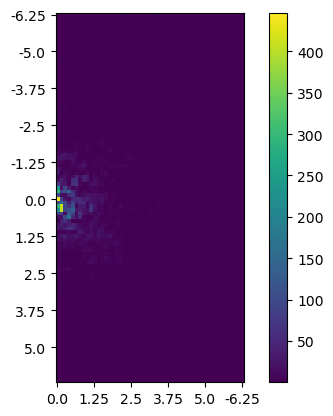

In [10]:
plt.imshow(np.fft.fftshift(Anomalies_spectra[0,:,:51],axes=0))
plt.xticks(np.arange(0,51,10),(kx[0,:51])[::10])
plt.yticks(np.arange(0,100,10),(np.fft.fftshift(ky[:,0]))[::10])
plt.colorbar()

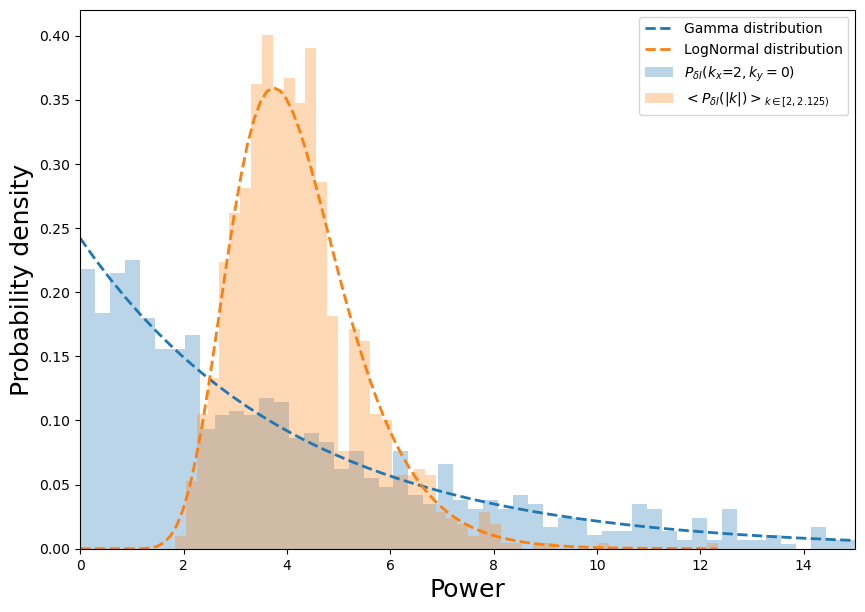

In [13]:
import scipy as sc
plt.figure(figsize=(10,7))

index_freq=16
index_rad=index_freq+1-init_freq_index

#kx=1, ky=0
plt.hist(Anomalies_spectra[:,0,index_freq],bins=100,density=True,\
         label=r'$P_{\delta I}(k_x$'+'={:.0f}'.format(k_values[index_freq])+r'$,k_y=0)$',alpha=0.3)

single_scale=Anomalies_spectra[:,0,index_freq].mean()
x=np.linspace(0,Anomalies_spectra[:,0,index_freq].max(),100)
plt.plot(x,gamma.pdf(x,1,0,single_scale),label='Gamma distribution',linestyle='--',linewidth=2,color='C0')


#2<=k<2.125
aggregated_spectra=(Anomalies_spectra[:,:,:51]*Ring_masks[index_rad]).sum(axis=(1,2))/(Ring_masks[index_rad].sum())
shape_marg=Ring_masks[index_rad].sum()

plt.hist(aggregated_spectra,bins=50,density=True,label=r'$<P_{\delta I}(|k|)>_{k \in [2,2.125)}$',color='C1',alpha=0.3)

LN_gamma,LN_mu,LN_sigma=infer_LogNorm_params(Radial_spectra[:,index_rad])

x=np.linspace(0,aggregated_spectra.max(),100)
plt.plot(x,lognorm.pdf(x,s=LN_sigma,loc=0,scale=np.exp(LN_mu)),label='LogNormal distribution',linestyle='--',linewidth=2,color='C1')



plt.xlim(0,15)
plt.xlabel('Power',fontsize=FS)
plt.ylabel('Probability density',fontsize=FS)
plt.legend()
plt.show()

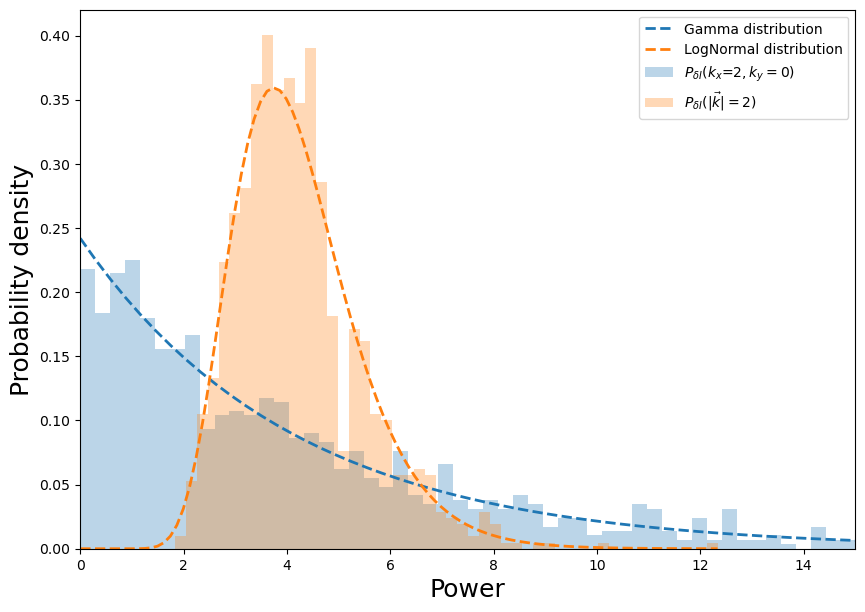

In [16]:
import scipy as sc
plt.figure(figsize=(10,7))

index_freq=16
index_rad=index_freq+1-init_freq_index

#kx=1, ky=0
plt.hist(Anomalies_spectra[:,0,index_freq],bins=100,density=True,\
         label=r'$P_{\delta I}(k_x$'+'={:.0f}'.format(k_values[index_freq])+r'$,k_y=0)$',alpha=0.3)

single_scale=Anomalies_spectra[:,0,index_freq].mean()
x=np.linspace(0,Anomalies_spectra[:,0,index_freq].max(),100)
plt.plot(x,gamma.pdf(x,1,0,single_scale),label='Gamma distribution',linestyle='--',linewidth=2,color='C0')


#2<=k<2.125
aggregated_spectra=(Anomalies_spectra[:,:,:51]*Ring_masks[index_rad]).sum(axis=(1,2))/(Ring_masks[index_rad].sum())
shape_marg=Ring_masks[index_rad].sum()

#plt.hist(aggregated_spectra,bins=50,density=True,label=r'$<P_{\delta I}(|k|)>_{k \in [2,2.125)}$',color='C1',alpha=0.3)
plt.hist(aggregated_spectra,bins=50,density=True,label=r'$P_{\delta I}(|\vec{k}|=2)$',color='C1',alpha=0.3)


LN_gamma,LN_mu,LN_sigma=infer_LogNorm_params(Radial_spectra[:,index_rad])

x=np.linspace(0,aggregated_spectra.max(),100)
plt.plot(x,lognorm.pdf(x,s=LN_sigma,loc=0,scale=np.exp(LN_mu)),label='LogNormal distribution',linestyle='--',linewidth=2,color='C1')



plt.xlim(0,15)
plt.xlabel('Power',fontsize=FS)
plt.ylabel('Probability density',fontsize=FS)
plt.legend()
plt.show()

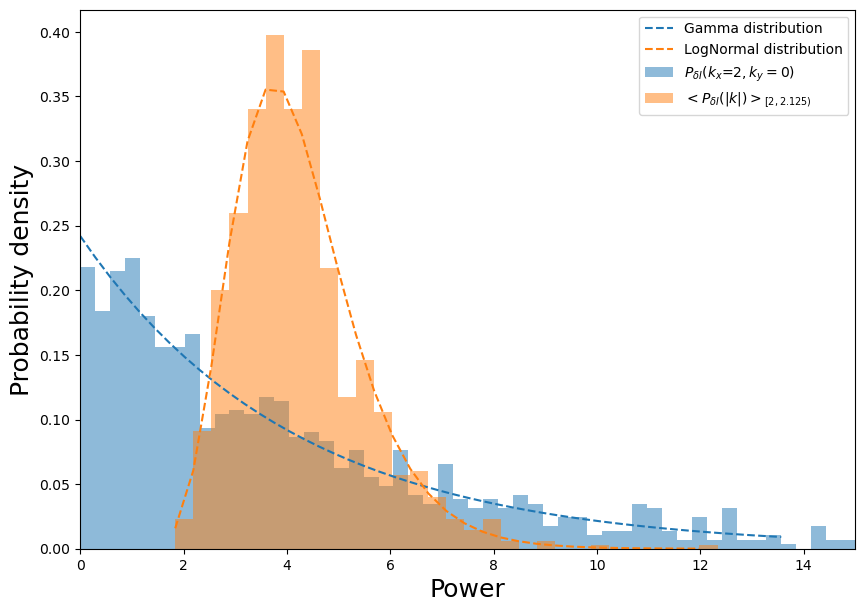

In [12]:
import scipy as sc
plt.figure(figsize=(10,7))

index_freq=16
index_rad=index_freq+1-init_freq_index

#kx=1, ky=0
distr_single,x_single=np.histogram(Anomalies_spectra[:,0,index_freq],bins=100,density=True)
index_single_lim=(np.where(distr_single==0)[0]).min()
#plt.plot(x_single[:index_single_lim],distr_single[:index_single_lim],label=r'$P_{\delta I}(k_x$'+'={:.0f}'.format(k_values[index_freq])+r'$,k_y=0)$')
plt.hist(Anomalies_spectra[:,0,index_freq],bins=100,density=True,label=r'$P_{\delta I}(k_x$'+'={:.0f}'.format(k_values[index_freq])+r'$,k_y=0)$',alpha=0.5)


single_scale=Anomalies_spectra[:,0,index_freq].mean()
#plt.plot(x_single[:index_single_lim],gamma.pdf(x_single[:index_single_lim],1,0,single_scale),label=r'$Gamma[\alpha=1$'+r'$, \ \theta=$'+'{:.1f}]'.format(single_scale),linestyle='--')
plt.plot(x_single[:index_single_lim],gamma.pdf(x_single[:index_single_lim],1,0,single_scale),label='Gamma distribution',linestyle='--',color='C0')


#1<=k<1.125
aggregated_spectra=(Anomalies_spectra[:,:,:51]*Ring_masks[index_rad]).sum(axis=(1,2))/(Ring_masks[index_rad].sum())
shape_marg=Ring_masks[index_rad].sum()
distr_marg,x_marg=np.histogram(aggregated_spectra,bins=30,density=True)
#plt.plot(x_marg[:-1],distr_marg,label=r'$<P_{\delta I}>_{k} \ for \ k \ \in$'+' [{:.0f},{:.3f})'.format(k_values[index_freq],k_values[index_freq+1]),color='C3')
#plt.plot(x_marg[:-1],distr_marg,label=r'$<P_{\delta I}>_{[k,k+dk)}$'+' for k=2',color='C3')
#plt.plot(x_marg[:-1],distr_marg,label=r'$<P_{\delta I}(|k|)>_{[2,2.125)}$',color='C3')
plt.hist(aggregated_spectra,bins=30,density=True,label=r'$<P_{\delta I}(|k|)>_{[2,2.125)}$',color='C1',alpha=0.5)




#plt.plot(x_marg[:19],gamma.pdf(x_marg[:19],shape_marg,0,single_scale/shape_marg),label=r'$Gamma(\alpha=$' +'{:.0f}'.format(shape_marg)+r'$, \ \theta=$'+'{:.1f})'.format(single_scale/shape_marg),linestyle='--')
#plt.plot(x_marg[:-1],lognorm.pdf(x_marg[:-1],s=np.log(aggregated_spectra).std(),loc=0,scale=np.exp(np.log(aggregated_spectra).mean())),label=r'$LogNorm[\mathbb{E}(log(<P_{\delta I}>_{k})),Var(log(<P_{\delta I}>_{k})]$',linestyle='--',color='r')


#LN_sigma=jnp.sqrt(jnp.log(1+Radial_spectra.var()/jnp.power(Radial_spectra.mean(),2)))
#LN_mu=jnp.log(Radial_spectra.mean())-jnp.power(LN_sigma,2)/2

LN_gamma,LN_mu,LN_sigma=infer_LogNorm_params(Radial_spectra[:,index_rad])
plt.plot(x_marg[:-1],lognorm.pdf(x_marg[:-1],s=LN_sigma,loc=0,scale=np.exp(LN_mu)),label='LogNormal distribution',linestyle='--',color='C1')



plt.xlim(0,15)
plt.xlabel('Power',fontsize=FS)
plt.ylabel('Probability density',fontsize=FS)
plt.legend()
plt.show()

In [346]:
k_values

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
       2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 ,
       3.375, 3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125, 4.25 , 4.375,
       4.5  , 4.625, 4.75 , 4.875, 5.   , 5.125, 5.25 , 5.375, 5.5  ,
       5.625, 5.75 , 5.875, 6.   , 6.125])

# GRF

In [5]:
get_GRF=Inference.GRF_getters(True)
k_grid,nonsingular_k_grid=get_k_grid(100,0.08)
zero_mean_mask=np.ones_like(nonsingular_k_grid)
zero_mean_mask[0,0]=0

GRF_params=[-7,2]
PS=nonsingular_Power_spectrum(GRF_params,nonsingular_k_grid)
k_vector=np.fft.fftfreq(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)
kx,ky=np.meshgrid(k_vector,k_vector)

xgrid,ygrid=Observation_conditions.pixel_grid.pixel_coordinates
ra_at_xy_0,dec_at_xy_0=Observation_conditions.pixel_grid.radec_at_xy_0

In [6]:
GRF_params=[-7,2]
get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF([-7,3],1)
initial=deepcopy(GRF_potential)

Text(0, 0.5, '$\\delta \\psi$')

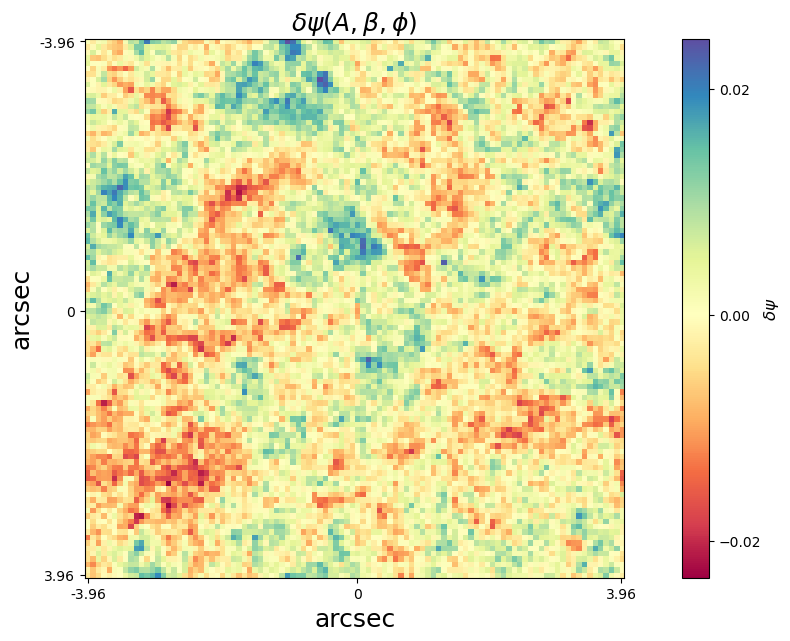

In [22]:
GRF_potential=get_GRF([-7.5,2],2)

fig=plt.figure(figsize=(15,7))
im=plt.imshow(GRF_potential,cmap='Spectral',norm=mpl.colors.TwoSlopeNorm(0))
plt.xticks([0,50,100-1],[ra_at_xy_0,0,-ra_at_xy_0])
plt.xlabel('arcsec',fontsize=FS)
plt.yticks([0,50,100-1],[ra_at_xy_0,0,-ra_at_xy_0])
plt.ylabel('arcsec',fontsize=FS)
plt.title(r'$\delta \psi (A,\beta,\phi)$',fontsize=FS)
cbar=fig.colorbar(im,ticks=[math.ceil(GRF_potential.min()*1e+2)/1e+2,0,math.floor(GRF_potential.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel(r'$\delta \psi$',rotation=90,fontsize=12,labelpad=0)


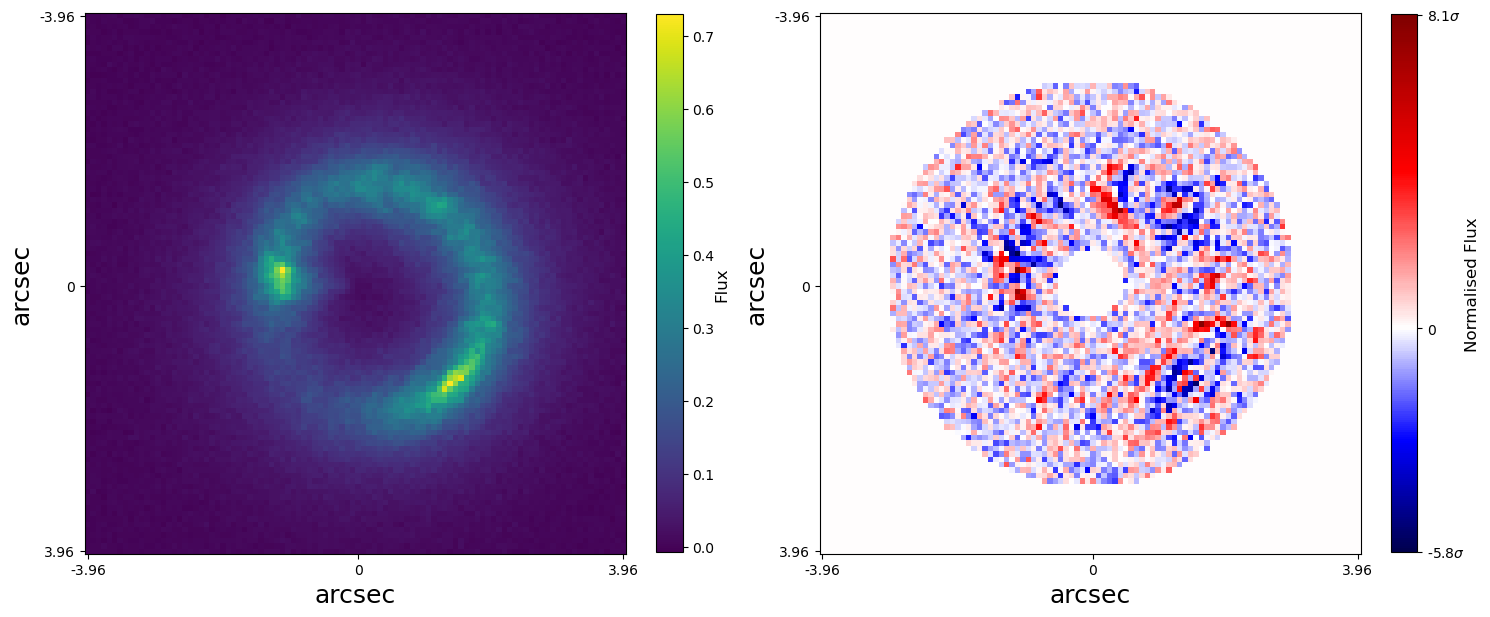

In [7]:
GRF_params=[-7.6,2.]
GRF_seed_index=2

get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,GRF_seed_index)

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

normalised_masked_residuals=((simulated_image-Image_unperturbed_noiseless)*Observation_conditions.annulus_mask)/np.sqrt(Observation_conditions.noise_var)
colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]

fig,ax=plt.subplots(1,2,figsize=(15,7))

img_arr=[]

img_arr+=[ax[0].imshow(simulated_image)]
cbar=fig.colorbar(img_arr[0],ax=ax[0],fraction=0.045)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)

img_arr+=[ax[1].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
cbar=fig.colorbar(img_arr[1],ticks=[math.ceil(normalised_masked_residuals.min()*1e+2)/1e+2,0,math.floor(normalised_masked_residuals.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    #axis.set_title(titles[i],fontsize=FS)
    axis.set_xticks([0,50,100-1])
    axis.set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0])
    axis.set_yticks([0,50,100-1])
    axis.set_yticklabels([ra_at_xy_0,0,-ra_at_xy_0])
    axis.set_xlabel('arcsec',fontsize=FS)
    axis.set_ylabel('arcsec',fontsize=FS)

plt.tight_layout()
#plt.show()

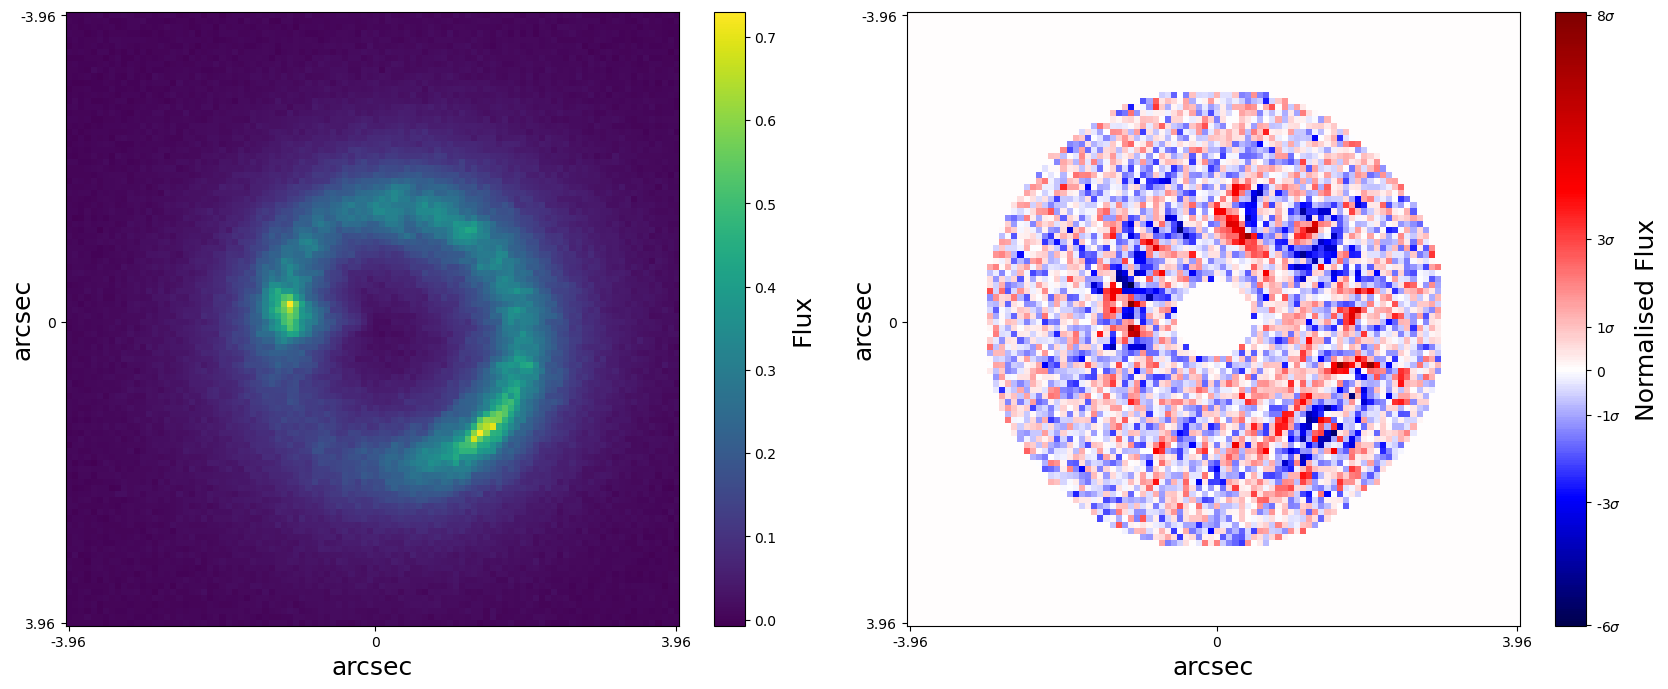

In [24]:
GRF_params=[-7.6,2.]
GRF_seed_index=2

get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,GRF_seed_index)

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

normalised_masked_residuals=((simulated_image-Image_unperturbed_noiseless)*Observation_conditions.annulus_mask)/np.sqrt(Observation_conditions.noise_var)
colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,-3,-1,0,1,3,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]

fig,ax=plt.subplots(1,2,figsize=(17,7))

img_arr=[]

img_arr+=[ax[0].imshow(simulated_image)]
cbar=fig.colorbar(img_arr[0],ax=ax[0],fraction=0.045)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=10)

img_arr+=[ax[1].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
cbar=fig.colorbar(img_arr[1],ticks=colorborders,fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=FS,labelpad=10)

labelarr=np.array(['{:.0f}'.format(colorborders[i])+r'$\sigma$' for i in range(len(colorborders))])
labelarr[math.ceil(len(labelarr)/3)]='0'
cbar.ax.set_yticklabels(labelarr)

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    #axis.set_title(titles[i],fontsize=FS)
    axis.set_xticks([0,50,100-1])
    axis.set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0])
    axis.set_yticks([0,50,100-1])
    axis.set_yticklabels([ra_at_xy_0,0,-ra_at_xy_0])
    axis.set_xlabel('arcsec',fontsize=FS)
    axis.set_ylabel('arcsec',fontsize=FS,labelpad=-10)

plt.tight_layout()
#plt.show()

(-0.5, 99.5, 99.5, -0.5)

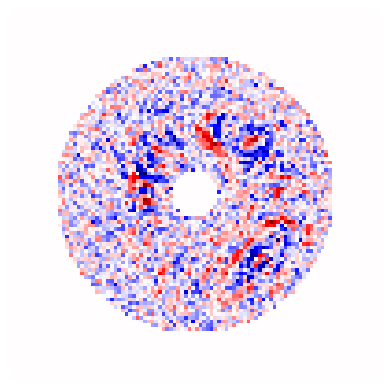

In [108]:
plt.imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.axis('off')

In [10]:
k_grid,_=get_k_grid(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)

In [11]:
q=compute_radial_spectrum(simulated_image-Image_unperturbed_noiseless,Observation_conditions.annulus_mask,k_grid,Observation_conditions.frequencies)

In [17]:
Grid_batch32=np.load('../Processing_scripts/results/Anomalies/anomalies_grid_node_{:.0f}_batch_{:.0f}.npz'.format(2,32))['arr_0']

In [18]:
Grid_batch32.shape

(32, 16, 100, 100, 100)

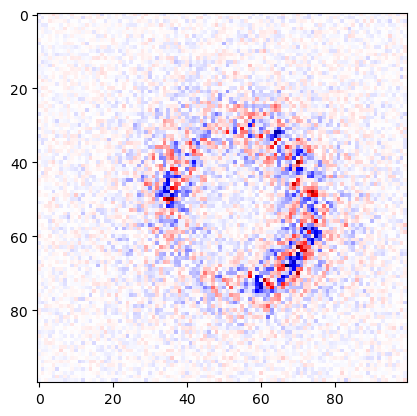

In [21]:
plt.imshow(Grid_batch32[-1,0,0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))

In [84]:
def anomalies_to_radial_spectrum(anomaly_image,Observation_conditions,k_grid):
    radial_spectrum=compute_radial_spectrum(anomaly_image,Observation_conditions.annulus_mask,k_grid,Observation_conditions.frequencies)
    return radial_spectrum

anomalies_to_radial_spectrum_pure=lambda anomaly: \
    anomalies_to_radial_spectrum(anomaly,Observation_conditions,k_grid)

anomalies_to_radial_spectrum_seeds=lambda anomaly_AB_row: jax.vmap(anomalies_to_radial_spectrum_pure,in_axes=0)(anomaly_AB_row)
anomalies_to_radial_spectrum_Betas=lambda anomaly_A_row: jax.vmap(anomalies_to_radial_spectrum_seeds,in_axes=0)(anomaly_A_row)
anomalies_to_radial_spectrum_grid_pmapped=jax.pmap(anomalies_to_radial_spectrum_Betas)


In [98]:
q=np.ones((32,16,100,46))
spectra_row=np.zeros((32,0,100,46))

In [113]:
spectra_row=np.append(spectra_row,q,axis=1)

In [114]:
spectra_row.shape

(32, 128, 100, 46)

In [115]:
spectra_grid=np.zeros((0,128,100,46))

In [123]:
spectra_grid=np.append(spectra_grid,spectra_row,axis=0)

In [124]:
spectra_grid.shape

(128, 128, 100, 46)

In [90]:
res.shape

(16, 100, 46)

In [88]:
Batches_array

array([  0,  16,  32,  48,  64,  80,  96, 112])

In [65]:
q=anomalies_to_radial_spectrum_pure(Grid_batch32[-1,-1,1])

In [66]:
Grid_batch32[:,:,:10].shape

(32, 16, 10, 100, 100)

In [85]:
start_time=time.time()
res=anomalies_to_radial_spectrum_grid_pmapped(Grid_batch32)
end_time=time.time()

ValueError: compiling computation that requires 32 logical devices, but only 1 XLA devices are available (num_replicas=32, num_partitions=1)

In [73]:

res=jax.vmap(anomalies_to_radial_spectrum_pure,in_axes=0)(Grid_batch32[0,0,:])

In [75]:
res.shape

(100, 46)

In [82]:
res=anomalies_to_radial_spectrum_Betas(Grid_batch32[-1])

In [83]:
res.shape

(16, 100, 46)

In [46]:
q=anomalies_to_radial_spectrum(-1,-1,1,Grid_batch32,Observation_conditions,k_grid)
anomalies_to_radial_spectrum_pure=lambda anomaly: \
    anomalies_to_radial_spectrum(anomaly,Observation_conditions,k_grid)

seeds_array=np.arange(100)
anomalies_to_radial_spectrum_seeds= lambda logA_index,Beta_index: jax_map(lambda Phase_index: \
                                                                          anomalies_to_radial_spectrum_pure(logA_index,Beta_index,Phase_index),seeds_array) 


In [47]:
res=jax.jit(anomalies_to_radial_spectrum_pure)(-1,8,0)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
While tracing the function <lambda> at /var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_31612/3953437558.py:2 for jit, this concrete value was not available in Python because it depends on the value of the argument 'logA_index'.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [43]:
res

DeviceArray([4.04138500e-04, 3.78853581e-04, 3.05491470e-04,
             3.86445049e-04, 5.29988981e-04, 5.99358189e-04,
             6.28335393e-04, 1.08089033e-03, 8.38534422e-04,
             9.04538582e-04, 9.46797224e-04, 6.91582869e-04,
             5.18990143e-04, 5.73975954e-04, 4.52952813e-04,
             5.67602653e-04, 6.26846250e-04, 4.81464418e-04,
             5.03411751e-04, 4.81414556e-04, 5.58061066e-04,
             4.72666467e-04, 4.60797286e-04, 5.43932657e-04,
             4.09264400e-04, 3.98163007e-04, 4.07091648e-04,
             3.64996858e-04, 3.29894651e-04, 2.86863704e-04,
             2.35623441e-04, 1.82767851e-04, 2.28806619e-04,
             2.24427085e-04, 1.85281989e-04, 2.01964876e-04,
             1.68168545e-04, 1.57954535e-04, 1.74651132e-04,
             1.43987182e-04, 1.47146700e-04, 1.49575344e-04,
             1.34329714e-04, 1.06254776e-04, 1.01467041e-04,
             9.80376698e-05], dtype=float64)

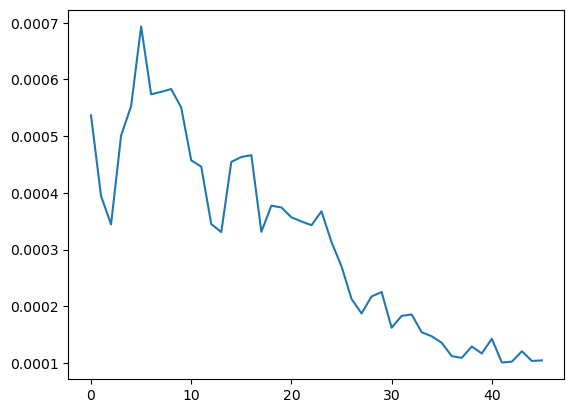

In [30]:
plt.plot(q)

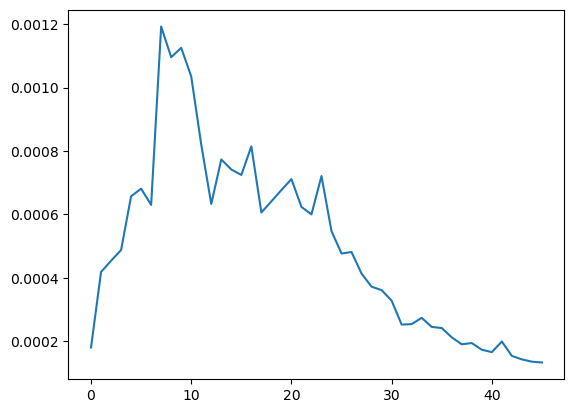

In [26]:
plt.plot(q)

In [22]:
Grid_batch32.shape

(32, 16, 100, 100, 100)

In [ ]:
jax.vmap(jnp.fft.fft2)

In [13]:
q.shape

(46,)

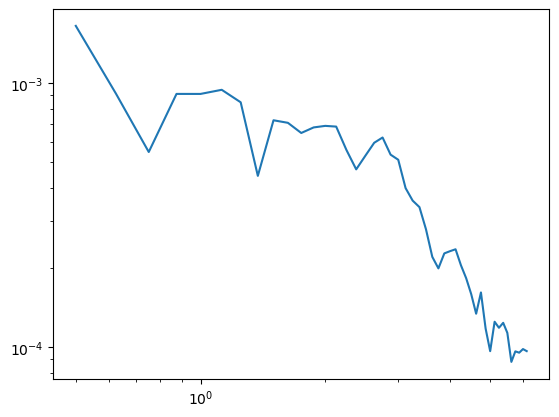

In [15]:
plt.loglog(Observation_conditions.frequencies,q)

In [111]:
spec=np.fft.fftshift(np.fft.fft2(simulated_image-Image_unperturbed_noiseless))[:,50:]
power_spec=np.abs(spec)**2
ks=np.fft.fftshift(k_grid)[:,50:]
k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(power_spec,ks)

Text(0.5, 0, 'Wavenumber, $arcsec^-1$')

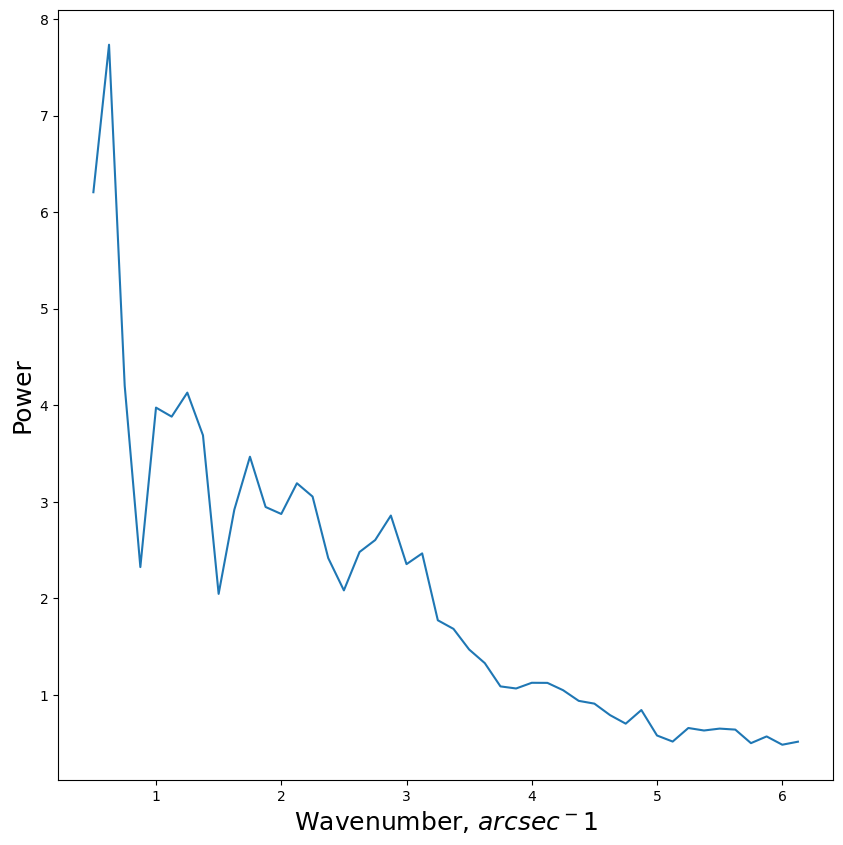

In [118]:
plt.figure(figsize=(10,10))
plt.plot(k_values[Observation_conditions.init_freq_index:],radial_spectrum[Observation_conditions.init_freq_index:])
plt.ylabel('Power',fontsize=FS)
plt.xlabel('Wavenumber, '+r'$arcsec^-1$',fontsize=FS)

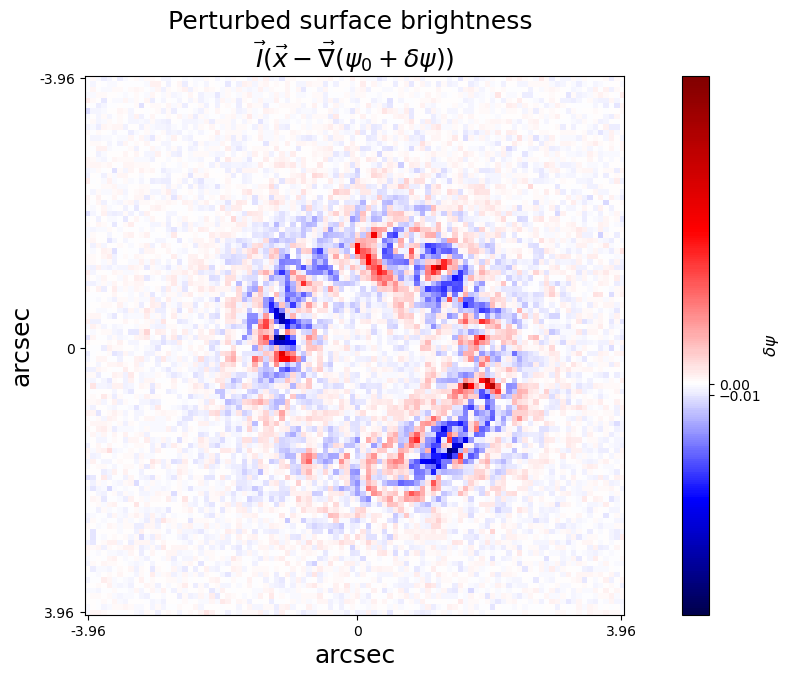

In [64]:
GRF_params=[-7.,2.]
GRF_seed_index=2

get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,GRF_seed_index)

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

fig=plt.figure(figsize=(15,7))
im=plt.imshow(simulated_image-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
#im=plt.imshow(simulated_image)
plt.xticks([0,50,100-1],[ra_at_xy_0,0,-ra_at_xy_0])
plt.xlabel('arcsec',fontsize=FS)
plt.yticks([0,50,100-1],[ra_at_xy_0,0,-ra_at_xy_0])
plt.ylabel('arcsec',fontsize=FS)
plt.title('Perturbed surface brightness \n'+r'$\vec{I}(\vec{x}-\vec{\nabla}(\psi_0+\delta \psi))$',fontsize=FS)
cbar=fig.colorbar(im,ticks=[math.ceil(simulated_image.min()*1e+2)/1e+2,0,math.floor(simulated_image.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel(r'$\delta \psi$',rotation=90,fontsize=12,labelpad=0)

plt.show()

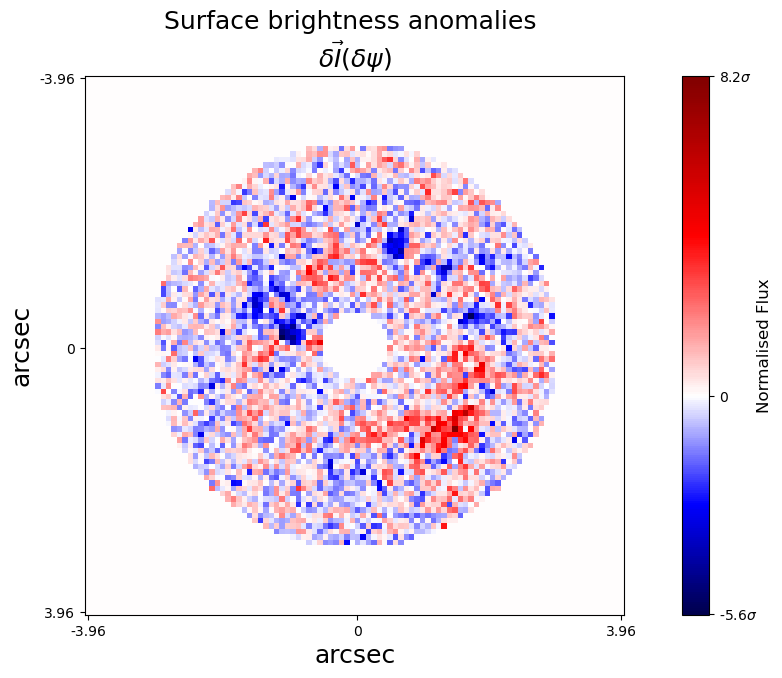

In [25]:
GRF_params=[-7.5,3.]
GRF_seed_index=1

get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,GRF_seed_index)

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)


normalised_masked_residuals=((simulated_image-Image_unperturbed_noiseless)*Observation_conditions.annulus_mask)/np.sqrt(Observation_conditions.noise_var)
colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]

fig=plt.figure(figsize=(15,7))
im=plt.imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
#im=plt.imshow(simulated_image)
plt.xticks([0,50,100-1],[ra_at_xy_0,0,-ra_at_xy_0])
plt.xlabel('arcsec',fontsize=FS)
plt.yticks([0,50,100-1],[ra_at_xy_0,0,-ra_at_xy_0])
plt.ylabel('arcsec',fontsize=FS)
plt.title('Surface brightness anomalies \n'+r'$\delta \vec{I}(\delta \psi)$',fontsize=FS)
cbar=fig.colorbar(im,ticks=[math.ceil(normalised_masked_residuals.min()*1e+2)/1e+2,0,math.floor(normalised_masked_residuals.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])

plt.show()

Text(0.5, 1.0, 'Power spectrum $P_{\\delta I}$')

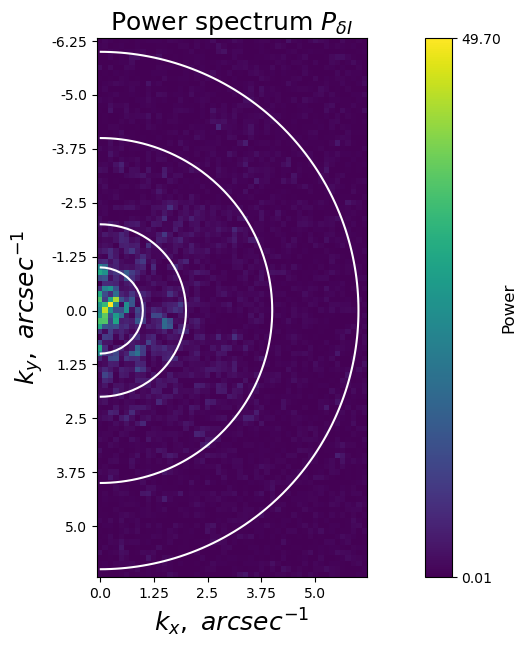

In [29]:
spec=np.fft.fftshift(np.fft.fft2(simulated_image-Image_unperturbed_noiseless))[:,50:]
power_spec=np.abs(spec)**2
fig=plt.figure(figsize=(15,7))

img=power_spec
im=plt.imshow(power_spec)

ks=np.fft.fftshift(k_grid)[:,50:]

plt.contour(ks,[1,2,4,6],colors='w')

plt.xticks(np.arange(0,50,10),kx[0,:50][::10])
plt.xlabel(r'$k_x, \ arcsec^{-1}$',fontsize=FS)
plt.yticks(np.arange(0,100,10),np.fft.fftshift(ky[:,0])[::10])
plt.ylabel(r'$k_y, \ arcsec^{-1}$',fontsize=FS)

cbar=fig.colorbar(im,ticks=[math.ceil(img.min()*1e+2)/1e+2,0,math.floor(img.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Power',rotation=90,fontsize=12,labelpad=0)

plt.title('Power spectrum '+r'$P_{\delta I}$',fontsize=FS)

In [51]:
k_values[4:]

array([0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125, 1.25 , 1.375, 1.5  ,
       1.625, 1.75 , 1.875, 2.   , 2.125, 2.25 , 2.375, 2.5  , 2.625,
       2.75 , 2.875, 3.   , 3.125, 3.25 , 3.375, 3.5  , 3.625, 3.75 ,
       3.875, 4.   , 4.125, 4.25 , 4.375, 4.5  , 4.625, 4.75 , 4.875,
       5.   , 5.125, 5.25 , 5.375, 5.5  , 5.625, 5.75 , 5.875, 6.   ,
       6.125])

In [52]:
k_grid.shape

(100, 100)

In [57]:
mask=(k_grid>=k_values[i-1])&(k_grid<k_values[i])

In [58]:
mask.shape

(100, 100)

In [59]:
power_spec[mask]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 50 but corresponding boolean dimension is 100

In [66]:
spec=np.fft.fftshift(np.fft.fft2(simulated_image-Image_unperturbed_noiseless))[:,50:]
power_spec=np.abs(spec)**2
ks=np.fft.fftshift(k_grid)[:,50:]

In [69]:
def map_spec_to_radial(Spectrum,k_grid):
    
    k_values=np.arange(0,np.abs(np.fft.fftfreq(100,0.08)).max(),0.125)
    radial_spectrum=np.zeros_like(k_values)
    radial_errorbars=np.zeros((2,len(k_values)))
    counts=np.zeros_like(k_values)
    
    for i in range(1,len(k_values)):
        mask=(k_grid>=k_values[i-1])&(k_grid<k_values[i])
        radial_spectrum[i]=Spectrum[mask].sum()/mask.sum()
        radial_errorbars[0,i]=radial_spectrum[i]-Spectrum[mask].min()
        radial_errorbars[1,i]=Spectrum[mask].max()-radial_spectrum[i]
        counts[i]=mask.sum() 
    return k_values,radial_spectrum,radial_errorbars,counts

In [70]:
spec=np.fft.fft2(simulated_image-Image_unperturbed_noiseless)[:,:50]
power_spec=np.abs(spec)**2
k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(power_spec,k_grid[:,:50])

In [74]:
k_grid[:,:50].shape

(100, 50)

In [75]:
len(radial_spectrum)

50

In [76]:
len(radial_spectrum[4:])

46

In [77]:
len(k_values[4:])

46

In [104]:
full_freq_vector=np.fft.fftshift(np.fft.fftfreq(Observation_conditions.pixel_number,Observation_conditions.pixel_scale))

In [105]:
full_freq_vector

array([-6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625, -5.5  , -5.375,
       -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625, -4.5  , -4.375,
       -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625, -3.5  , -3.375,
       -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625, -2.5  , -2.375,
       -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625, -1.5  , -1.375,
       -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375,
       -0.25 , -0.125,  0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,
        0.75 ,  0.875,  1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,
        1.75 ,  1.875,  2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,
        2.75 ,  2.875,  3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,
        3.75 ,  3.875,  4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,
        4.75 ,  4.875,  5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,
        5.75 ,  5.875,  6.   ,  6.125])

In [153]:
def Spectrum_radial_averaging(spectrum,k_grid_half,frequencies):

    shape_spectrum=k_grid_half.shape
    length_radial=len(frequencies)

    #Mask rings with increasing integer radius (in pixels)
    Ring_masks=np.zeros((length_radial,shape_spectrum[0],shape_spectrum[1]))
    for i in range(length_radial-1):
        #Chose ring of given radius
        Ring_masks[i]=np.logical_and(k_grid_half>=frequencies[i],k_grid_half<frequencies[i+1])

    #max negative freq 6.25
    dk=frequencies[1]-frequencies[0]
    Ring_masks[-1]=np.logical_and(k_grid_half>=frequencies[-1],k_grid_half<frequencies[-1]+dk)
    
    #Number of pixels in ring
    pix_in_bins=Ring_masks.sum(axis=(1,2))
    print(pix_in_bins)
    #Sum of image values in a ring with radius i
    scan_func= lambda _,Ring_mask: (1,jnp.sum(spectrum*Ring_mask))
    #Differentiable loop over rings
    sum_in_bins=jax.lax.scan(scan_func,0,Ring_masks)[1]

    radial_spectrum=sum_in_bins/pix_in_bins
    return radial_spectrum

def compute_radial_spectrum(image,annulus_mask,k_grid,frequencies):

    #Mask should have the same shape as image
    #it should be square
    assert annulus_mask.shape[0]==annulus_mask.shape[1]

    #Leave only region with Einstein ring
    masked_image=image*annulus_mask

    independent_spectrum_index=annulus_mask.shape[1]//2

    spectrum = jnp.fft.fft2(masked_image)[:, :independent_spectrum_index]
    power_spectrum = jnp.abs(spectrum) ** 2
    #unitary normalisation of the Fourier transform (look np.fft norm 'ortho')
    normalized_spectrum=power_spectrum/annulus_mask.sum()

    k_grid_half=k_grid[:,:independent_spectrum_index]
    Radial_spectrum=Spectrum_radial_averaging(normalized_spectrum,k_grid_half,frequencies)

    return Radial_spectrum

In [155]:
q=compute_radial_spectrum(simulated_image-Image_unperturbed_noiseless,Observation_conditions.annulus_mask,k_grid,Observation_conditions.frequencies)

[ 13.  21.  19.  25.  29.  29.  35.  33.  41.  47.  45.  49.  49.  59.
  61.  61.  63.  73.  69.  71.  77.  85.  89.  83.  85.  97.  95. 105.
 101. 105. 115. 105. 117. 115. 129. 125. 119. 137. 133. 145. 139. 137.
 149. 147. 157. 153.]


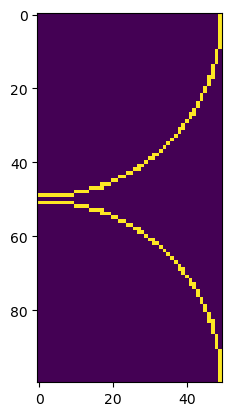

In [152]:
plt.imshow(Ring_masks[-1])

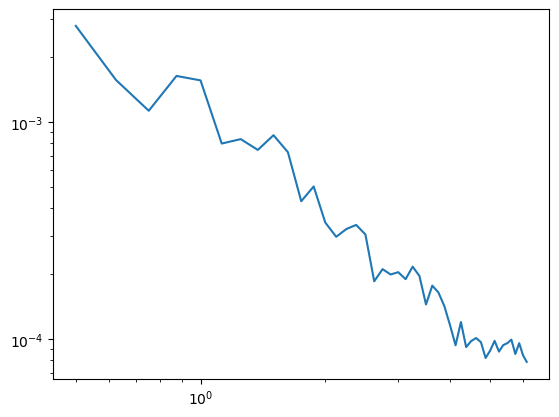

In [156]:
plt.plot(Observation_conditions.frequencies,q)
plt.xscale('log')
plt.yscale('log')




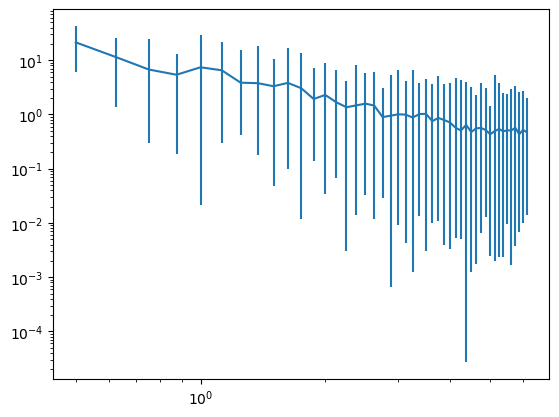

In [71]:
plt.errorbar(k_values[4:],radial_spectrum[4:],radial_errorbars[:,4:])
plt.xscale('log')
plt.yscale('log')



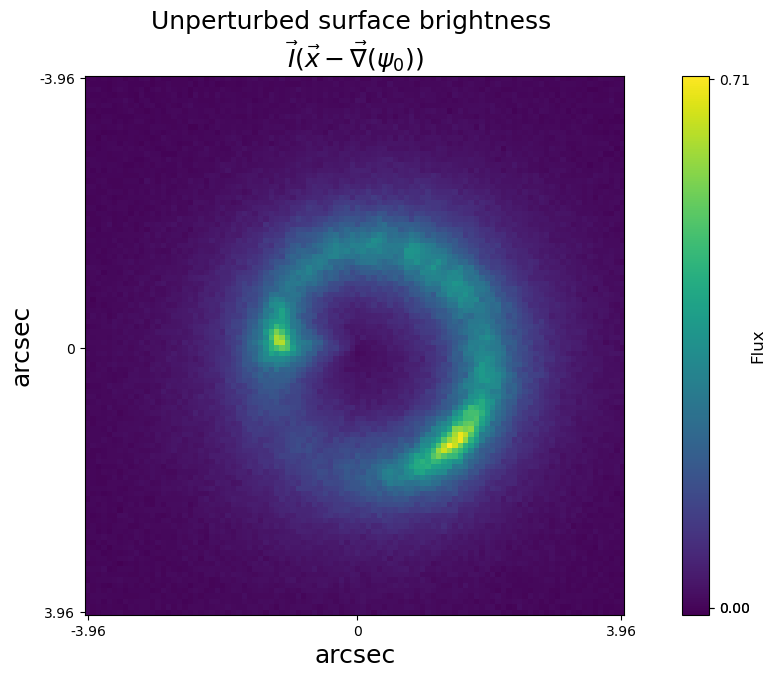

In [105]:
GRF_params=[-7.5,3.]
GRF_seed_index=1

get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,GRF_seed_index)

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)


fig=plt.figure(figsize=(15,7))
img=simulated_image
im=plt.imshow(simulated_image)
#im=plt.imshow(simulated_image)
plt.xticks([0,50,100-1],[ra_at_xy_0,0,-ra_at_xy_0])
plt.xlabel('arcsec',fontsize=FS)
plt.yticks([0,50,100-1],[ra_at_xy_0,0,-ra_at_xy_0])
plt.ylabel('arcsec',fontsize=FS)
plt.title('Unperturbed surface brightness \n'+r'$\vec{I}(\vec{x}-\vec{\nabla}(\psi_0))$',fontsize=FS)
cbar=fig.colorbar(im,ticks=[math.ceil(img.min()*1e+2)/1e+2,0,math.floor(img.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)

plt.show()

# Unperturbed image

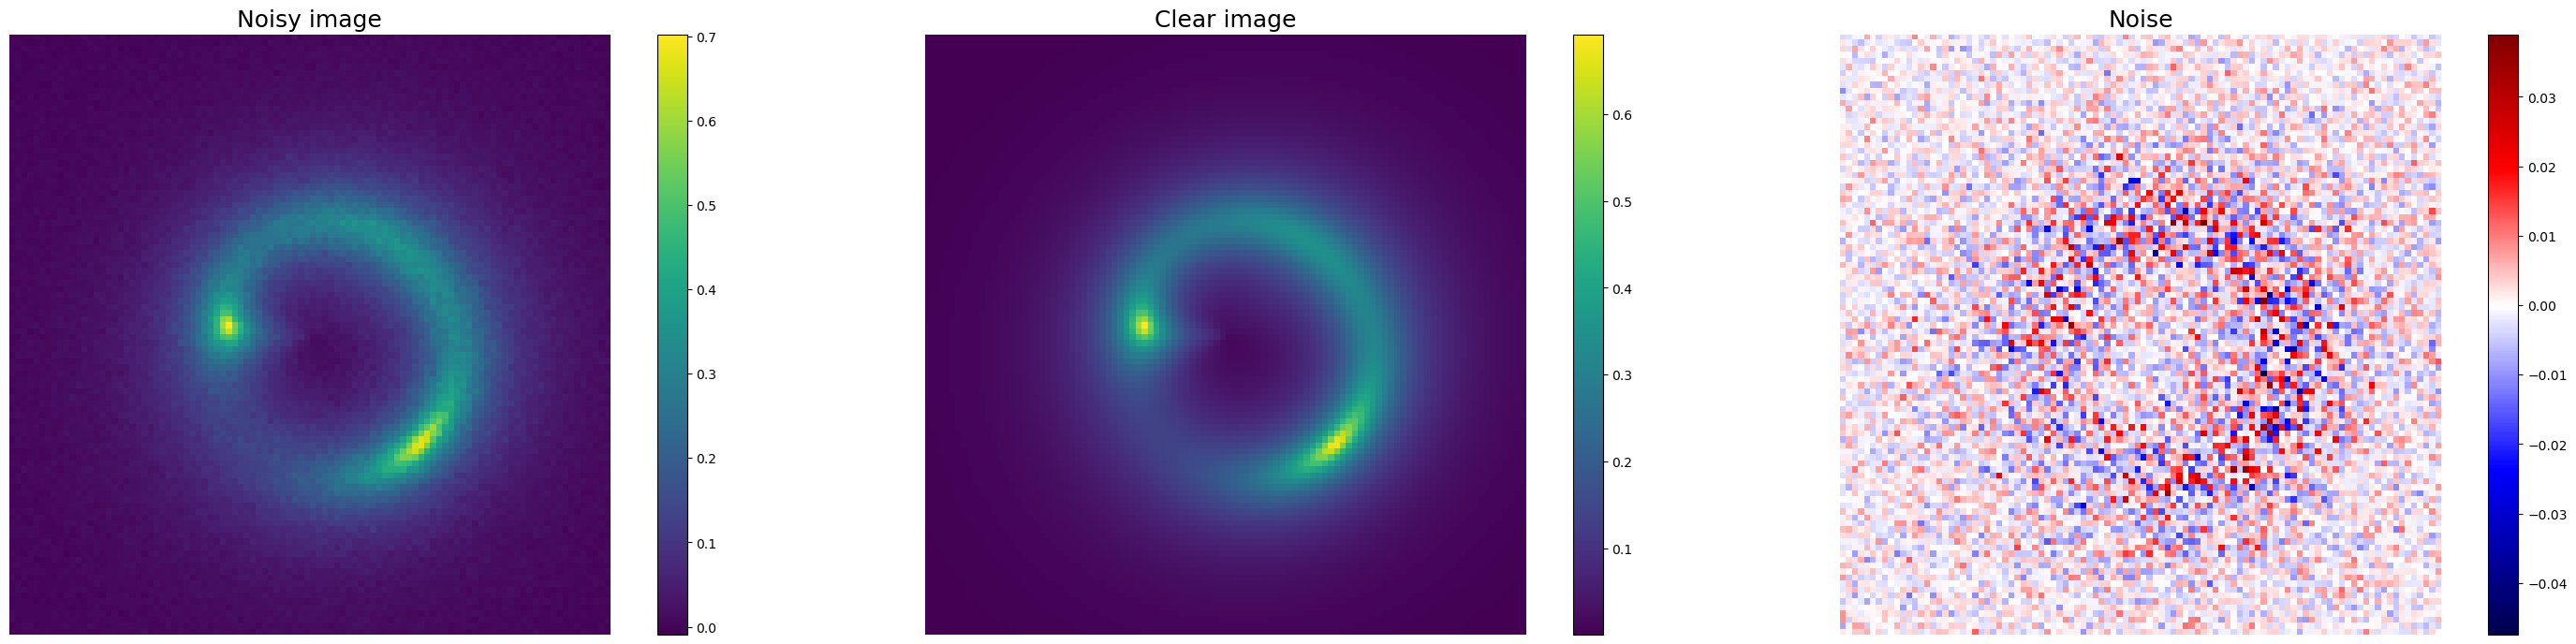

In [4]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

In [5]:
get_GRF=Inference.GRF_getters(True)
k_grid,nonsingular_k_grid=get_k_grid(100,0.08)
zero_mean_mask=np.ones_like(nonsingular_k_grid)
zero_mean_mask[0,0]=0

GRF_params=[-7,2]
PS=nonsingular_Power_spectrum(GRF_params,nonsingular_k_grid)
k_vector=np.fft.fftfreq(Observation_conditions.pixel_number,Observation_conditions.pixel_scale)
kx,ky=np.meshgrid(k_vector,k_vector)

xgrid,ygrid=Observation_conditions.pixel_grid.pixel_coordinates

In [150]:
def get_alpha_kappa(GRF_params,GRF_seed_index):
    
    GRF_potential=get_GRF(GRF_params,GRF_seed_index)
    true_alphax,true_alphay=Observation_conditions.LensImage_perturbed_noiseless.LensModel.alpha(xgrid,ygrid,[{},{},{'pixels': GRF_potential}],k=2)
    true_kappa=Observation_conditions.LensImage_perturbed_noiseless.LensModel.kappa(xgrid,ygrid,[{},{},{'pixels': GRF_potential}],k=2)
    
    PS=nonsingular_Power_spectrum(GRF_params,nonsingular_k_grid)*zero_mean_mask
    alphax=-nonsingular_k_grid.size*np.fft.fftshift(np.fft.ifft2(np.sqrt(PS)*2*np.pi*kx*Inference.Fourier_phase_tensor[GRF_seed_index])).imag
    alphay=-nonsingular_k_grid.size*np.fft.fftshift(np.fft.ifft2(np.sqrt(PS)*2*np.pi*ky*Inference.Fourier_phase_tensor[GRF_seed_index])).imag
    
    laplx=-nonsingular_k_grid.size*np.fft.fftshift(np.fft.ifft2(np.sqrt(PS)*(2*np.pi*kx)**2*Inference.Fourier_phase_tensor[GRF_seed_index])).real
    laply=-nonsingular_k_grid.size*np.fft.fftshift(np.fft.ifft2(np.sqrt(PS)*(2*np.pi*ky)**2*Inference.Fourier_phase_tensor[GRF_seed_index])).real
    kappa=(laplx+laply)/2
    
    expected_alphax_var=((2*np.pi*kx)**2*PS).sum()
    expected_alphay_var=((2*np.pi*ky)**2*PS).sum()
    expected_kappa_var=((2*np.pi*k_grid)**4*PS/4).sum()
    
    
    
    return [alphax,alphay,kappa],[true_alphax,true_alphay,true_kappa],[expected_alphax_var,expected_alphay_var,expected_kappa_var]

In [153]:
res=get_alpha_kappa([-7.5,3],1)

In [154]:
alphax,alphay,kappa=res[0]

Text(0, 0.5, '$\\delta \\alpha$, arcsec')

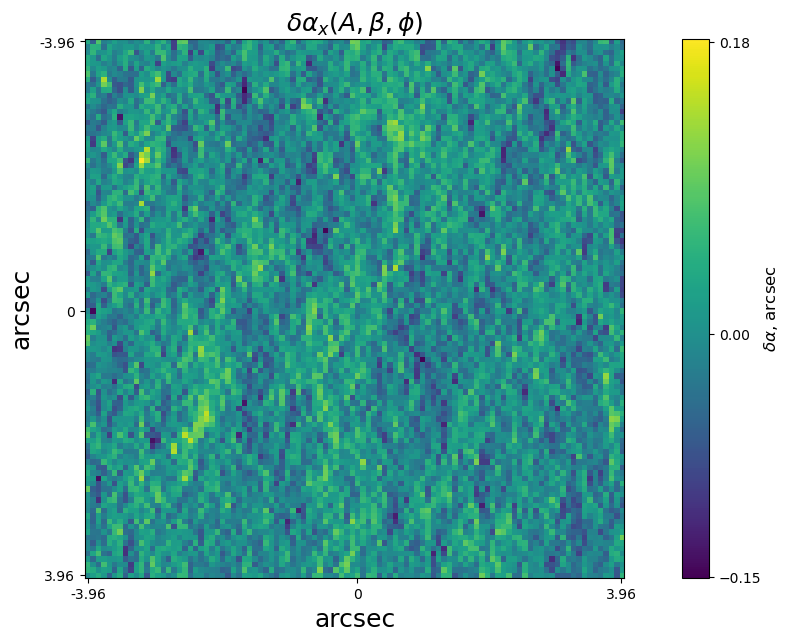

In [168]:
fig=plt.figure(figsize=(15,7))
img=alphax
im=plt.imshow(img,cmap='viridis',norm=mpl.colors.TwoSlopeNorm(0))
plt.xticks([0,50,100-1],[ra_at_xy_0,0,-ra_at_xy_0])
plt.xlabel('arcsec',fontsize=FS)
plt.yticks([0,50,100-1],[ra_at_xy_0,0,-ra_at_xy_0])
plt.ylabel('arcsec',fontsize=FS)
plt.title(r'$\delta \alpha_x (A,\beta,\phi)$',fontsize=FS)
cbar=fig.colorbar(im,ticks=[math.ceil(img.min()*1e+2)/1e+2,0,math.floor(img.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel(r'$\delta \alpha$'', arcsec',rotation=90,fontsize=12,labelpad=0)



# GRF Spectra grid

In [4]:
grid_size=128
logA_array=np.linspace(-9.7,-6.87,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
GRF_seeds_number=100

In [5]:
Spectra_grid=np.load('../Processing_scripts/results/Spectra_grid_node_0.npz')['arr_0']
for i in range(1,4):
    Spectra_grid=np.append(Spectra_grid,np.load('../Processing_scripts/results/Spectra_grid_node_{}.npz'.format(i))['arr_0'],axis=0)

In [6]:
SNR_grid=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:227: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


# Inference test

In [7]:

y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

def set_labels_plt(fontsize):
    plt.gca().set_yticklabels(yticklabels,fontsize=fontsize)
    plt.gca().set_xticklabels(xticklabels,fontsize=fontsize)
    
def plot_line(ax_row,data_image,residuals_image,GRF_potential,likelihood,Confidence_grid,SNR,\
              true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,ylabel,\
              logA_ind_lim=(0,160),Beta_ind_lim=(0,214),legend_flag=True,titles_flag=True):
    #Data
    im=ax_row[0].imshow(data_image)
    cbar=fig.colorbar(im,ax=ax_row[0],ticks=[0,0.2,0.4,0.6,math.floor(data_image.max()*100)/100],fraction=0.045)
    cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)
    
    #Potential
    im=ax_row[1].imshow(GRF_potential,cmap='Spectral',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=fig.colorbar(im,ax=ax_row[1],ticks=[math.ceil(GRF_potential.min()*1e+3)/1e+3,0,math.floor(GRF_potential.max()*1e+3)/1e+3],fraction=0.045)
    cbar.ax.set_ylabel(r'$\delta \psi$',rotation=90,fontsize=12,labelpad=0)
    
    #masked_resid=resids_images[i]*mask
    #norm_masked_resid=(resids_images[i]/np.sqrt(noise_vars[i]))*mask
    
    #Residuals
    normalised_masked_residuals=(residuals_image*Observation_conditions.annulus_mask)/np.sqrt(noise_var)
    colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]
    
    im=ax[i,2].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=fig.colorbar(im,ax=ax_row[2],ticks=colorborders,fraction=0.045)
    cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
    cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    #fig.colorbar(im,ax=ax[i,2],ticks=[math.ceil(resids_images[i].min()*1e+3)/1e+3,0,math.floor(resids_images[i].max()*1e+3)/1e+3],fraction=0.045)
    
    
    Crop_Beta_arr=Beta_array[Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_logA_arr=logA_array[logA_ind_lim[0]:logA_ind_lim[1]]
    Crop_likelihood=likelihood[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_confidence=Confidence_grid[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_SNR=SNR[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    
    
    Like_xticks=np.arange(10)
    Like_xticks=Like_xticks[np.where( (Like_xticks>=Crop_Beta_arr[0]) & (Like_xticks<=Crop_Beta_arr[-1]) )[0]]
    Like_yticks=np.arange(0,8)*0.5-9.5
    Like_yticks=Like_yticks[np.where( (Like_yticks>=Crop_logA_arr[0]) & (Like_yticks<=Crop_logA_arr[-1]) )[0]]
    
    
    plot_likelihood(ax_row[3],Crop_Beta_arr,Crop_logA_arr,Crop_confidence,Crop_SNR,true_logA_index-logA_ind_lim[0],true_Beta_index-Beta_ind_lim[0],\
                    pred_logA_index-logA_ind_lim[0],pred_Beta_index-Beta_ind_lim[0],Like_xticks,Like_yticks,legend_flag)
    
    ra_at_xy_0,dec_at_xy_0=Observation_conditions.pixel_grid.radec_at_xy_0
    
    for j in range(3):
        ax_row[j].set_xticks([0,50,100-1])
        ax_row[j].set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0])
        ax_row[j].set_xlabel('arcsec')
        
        ax_row[j].set_yticks([0,50,100-1])
        ax_row[j].set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
        ax_row[j].set_ylabel('arcsec',labelpad=-15)
        '''
        if j!=0:
            ax_row[j].set_yticks([0,50,100-1])
            ax_row[j].set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
            ax_row[j].set_ylabel('arcsec',labelpad=-15)
        else:
            ax_row[j].set_yticks([])
            ax_row[j].set_ylabel('arcsec',labelpad=20)
        '''
        
    if titles_flag:
        titles=['Imaging data','Potential perturbations','Normalised residuals','Perturbations confidence']
        for j in range(4):
            ax_row[j].set_title(titles[j],fontsize=FS)
        
    '''
    box=ax_row[3].get_position()
    box.x0 = box.x0 + 0.02 
    ax_row[3].set_position(box)
    
    sup_ax=ax_row[0].twiny().twinx()
    sup_ax.yaxis.set_label_position('left')
    sup_ax.set_xticks([])
    
    sup_ax.yaxis.tick_left()
    #sup_ax.set_yticks([])
    sup_ax.set_yticks([0,50,100-1])
    sup_ax.set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
    #sup_ax.set_ylabel('arcsec',labelpad=-15)
    
    
    sup_ax.set_ylabel(ylabel,fontsize=FS,rotation=0)
    #sup_ax.set_ylabel(r"${\rm log}(A)$",fontsize=FS,rotation=0)
    sup_ax.yaxis.set_label_coords(-0.3,0.38)
    '''

In [8]:
def conduct_inference(GRF_params,GRF_seed_index):
    get_GRF=Inference.GRF_getters(True)
    GRF_potential=get_GRF(GRF_params,GRF_seed_index)

    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

    simulate_perturbed_image=Observation_conditions.perturbed_image_getter
    simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)
    
    args_fit=Inference.differentiable_fit_image(simulated_image)

    simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
    fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

    residuals=simulated_image-fit_image
    spectrum=Inference.compute_radial_spectrum(residuals)

    true_logA_index=np.argmin(np.abs(logA_array-GRF_params[0]))
    true_Beta_index=np.argmin(np.abs(Beta_array-GRF_params[1]))

    likelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(spectrum,Spectra_grid,true_logA_index,true_Beta_index)
    logA_maxL_index,Beta_maxL_index=jnp.unravel_index(jnp.argmax(likelihood),likelihood.shape)
    
    return GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index

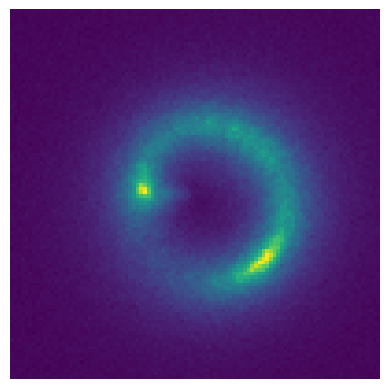

In [9]:
GRF_params=[-8.,2]
GRF_seed_index=1

get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,GRF_seed_index)

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

plt.imshow(simulated_image)
plt.axis('off')
plt.show()

In [10]:
results_low_SNR=conduct_inference([-8.7,2],1)

Uncertainties estimation took 0.2 seconds
Loss grid computation took 0.4 seconds
Confidence grid computation took 0.0 seconds


/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours+=[np.array(measure.find_contours(likelihood,isolevel))]


In [11]:
results_high_SNR=conduct_inference([-7.5,2],2)

Uncertainties estimation took 0.0 seconds
Loss grid computation took 0.4 seconds
Confidence grid computation took 0.0 seconds


In [12]:
results_low_Beta=conduct_inference([-8.21,0.5],3)

Uncertainties estimation took 0.0 seconds
Loss grid computation took 0.3 seconds
Confidence grid computation took 0.0 seconds


In [13]:
results_high_Beta=conduct_inference([-7.3,3.5],4)

Uncertainties estimation took 0.0 seconds
Loss grid computation took 0.4 seconds
Confidence grid computation took 0.0 seconds


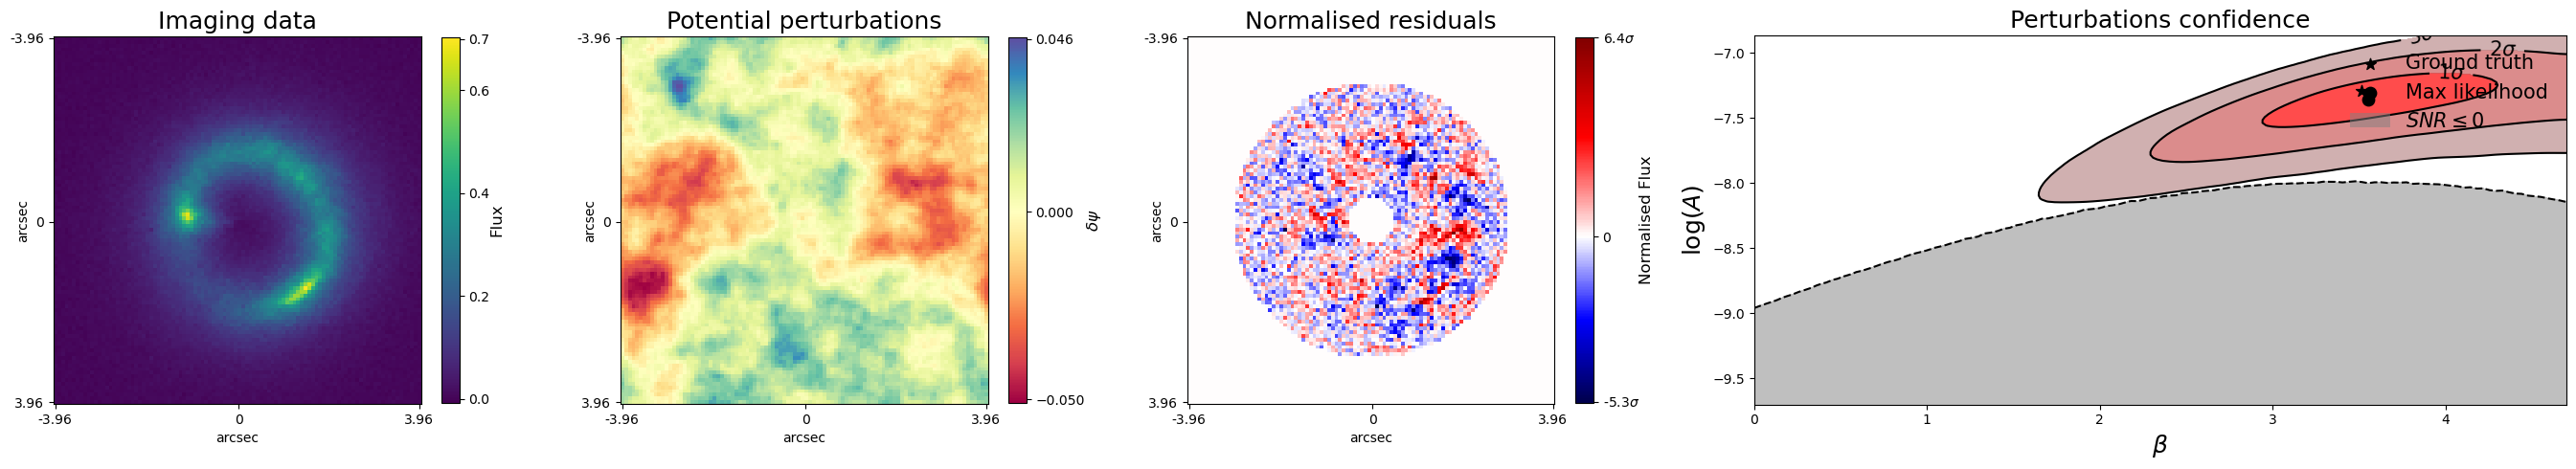

In [14]:
GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=results_high_Beta


from matplotlib import gridspec
fig=plt.figure(figsize=(27,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1])
ax=[]
for i in range(1):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)

plot_line(ax[0],simulated_image,residuals,GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index,ylabel,\
          logA_ind_lim=(0,128),Beta_ind_lim=(0,128),legend_flag=True)

plt.tight_layout(h_pad=3,w_pad=2)

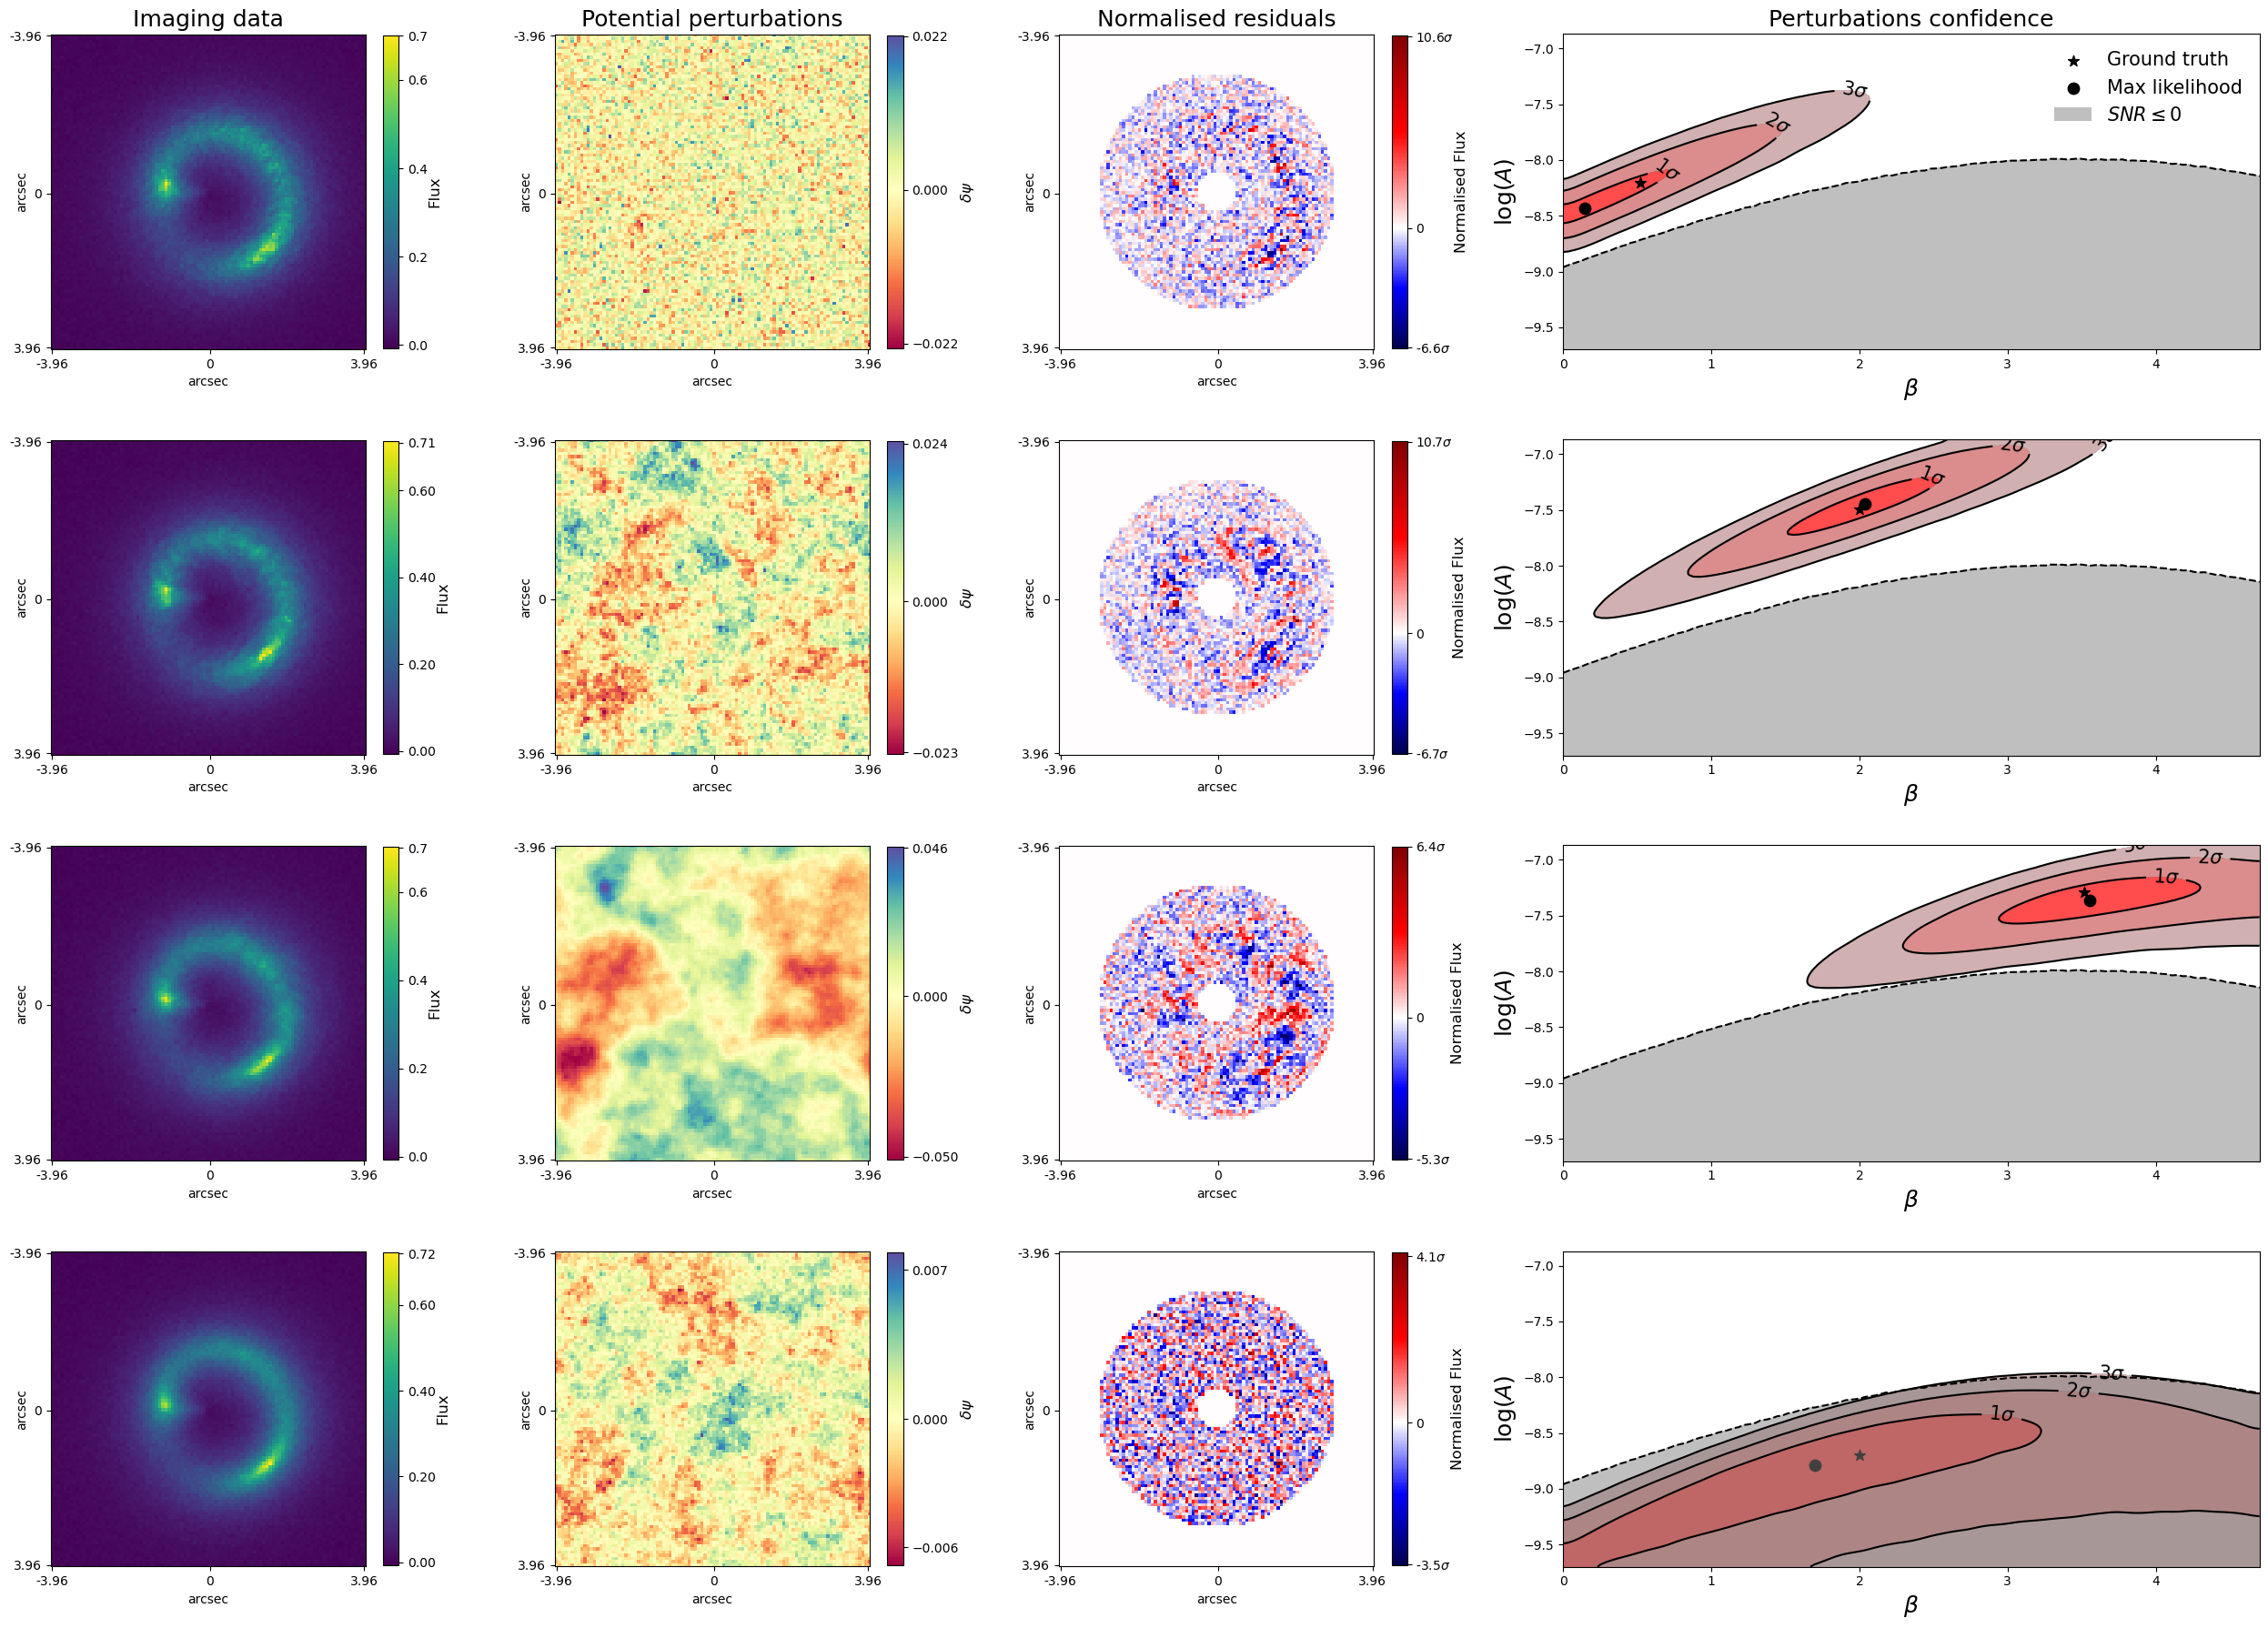

In [15]:
GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=results_high_Beta
from matplotlib import gridspec
fig=plt.figure(figsize=(25,18))
gs = gridspec.GridSpec(4, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1,1,1,1])
ax=[]
for i in range(4):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)

results_array=[results_low_Beta,results_high_SNR,results_high_Beta,results_low_SNR]

for i in range(4):
    GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,\
        pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=\
        results_array[i]
    
    if i==0:
        titles_flag=True
        legend_flag=True
    else:
        titles_flag=False
        legend_flag=False
    
    plot_line(ax[i],simulated_image,residuals,GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index,ylabel,\
          logA_ind_lim=(0,128),Beta_ind_lim=(0,128),legend_flag=legend_flag,titles_flag=titles_flag)

plt.tight_layout(h_pad=3,w_pad=2)

# New spectra grid

# GRF Spectra grid

In [24]:
grid_size=128
logA_array=np.linspace(-10.075,-6.9,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
GRF_seeds_number=100

In [25]:
Spectra_grid=np.load('../Processing_scripts/results/Radial_spectra/Spectra_grid.npz')['arr_0']

In [26]:
SNR_grid=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:227: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


In [57]:
logA_array[64]

-8.273858267716536

In [59]:
Beta_array[50]

1.8503937007874016

In [61]:
SNR_grid[80,50]

1.6432064052396402

In [5]:
MU_tensor=np.log(Spectra_grid).mean(axis=2)
MU_tensor_ext=np.tile(MU_tensor,GRF_seeds_number)
MU_tensor_ext=MU_tensor_ext.reshape((grid_size,grid_size,GRF_seeds_number,Spectra_grid.shape[-1]))
Sigma_tensor=np.sqrt(np.power(np.log(Spectra_grid)-MU_tensor_ext,2).sum(axis=2)/(Spectra_grid.shape[2]-1))

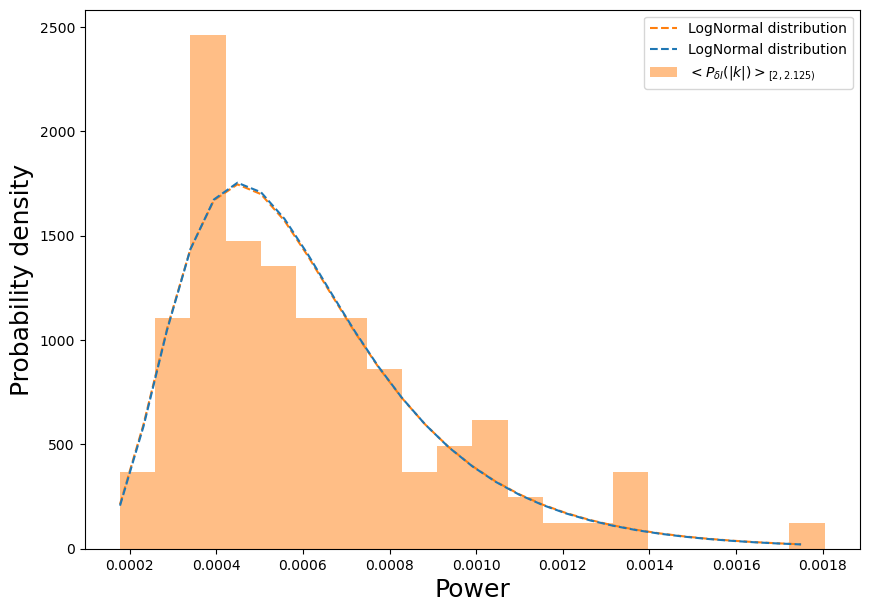

In [251]:
from scipy.stats import gamma,lognorm
import scipy as sc
plt.figure(figsize=(10,7))


index_freq=4
index_rad=index_freq+1-4

index_A=95
index_B=50

data=Spectra_grid[index_A,index_B,:,index_rad]

#1<=k<1.125
distr_marg,x_marg=np.histogram(data,bins=30,density=True)
plt.hist(data,bins=20,density=True,label=r'$<P_{\delta I}(|k|)>_{[2,2.125)}$',color='C1',alpha=0.5)

LN_gamma,LN_mu,LN_sigma=infer_LogNorm_params(data)
plt.plot(x_marg[:-1],lognorm.pdf(x_marg[:-1],s=LN_sigma,loc=0,scale=np.exp(LN_mu)),label='LogNormal distribution',linestyle='--',color='C1')

#LN_mu=np.log(data).mean()
#LN_sigma=np.sqrt(np.power(np.log(data)-LN_mu,2).sum()/(len(data)-1))

LN_mu=MU_tensor[index_A,index_B,index_rad]
LN_sigma=Sigma_tensor[index_A,index_B,index_rad]
plt.plot(x_marg[:-1],lognorm.pdf(x_marg[:-1],s=LN_sigma,loc=0,scale=np.exp(LN_mu)),label='LogNormal distribution',linestyle='--',color='C0')

plt.xlabel('Power',fontsize=FS)
plt.ylabel('Probability density',fontsize=FS)
plt.legend()
plt.show()

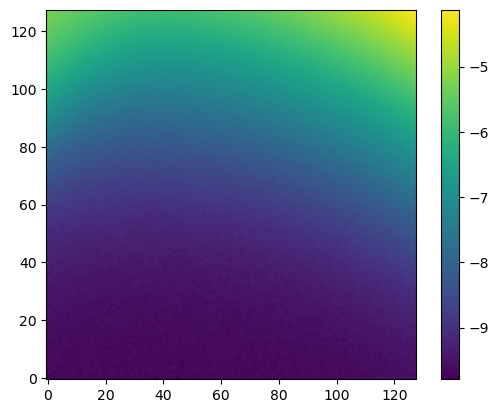

In [252]:
plt.imshow(MU_tensor[:,:,0])
plt.gca().invert_yaxis()
plt.colorbar()

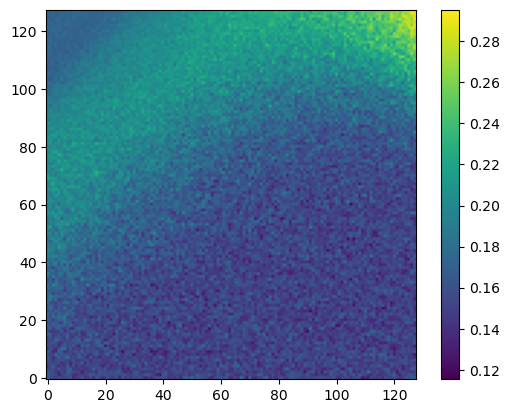

In [253]:
plt.imshow(Sigma_tensor[:,:,18])
plt.gca().invert_yaxis()
plt.colorbar()

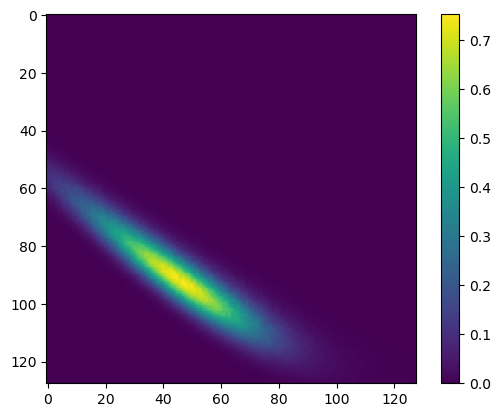

In [254]:
data_logSpectrum=np.log(Spectra_grid[98,55,0])
Loss_grid=jnp.mean(jnp.power((data_logSpectrum-MU_tensor)/Sigma_tensor,2),axis=-1)
plt.imshow(np.exp(-Loss_grid/2))
plt.colorbar()

In [275]:
from skimage import measure
def compute_Confidence_grid(likelihood):
    isolevels=likelihood.max()*np.linspace(1,0,101)
    contours=[]


    confidence_grid=np.zeros_like(likelihood)*np.nan

    #Compute isolevel contours
    for i,isolevel in enumerate(isolevels):
        contours+=[np.array(measure.find_contours(likelihood,isolevel))]

    confidence_levels=np.zeros_like(isolevels)

    #Compute cumulative probability enclosed in them
    for i,isolevel in enumerate(isolevels):
        above_isolevel_mask=(likelihood>=isolevel)
        confidence_levels[i]=np.nansum(likelihood*above_isolevel_mask)

        undefined_confidence_mask=np.isnan(confidence_grid)

        #Mask the region to be assigned with confidence
        confidence_mask=above_isolevel_mask*undefined_confidence_mask
        #Change selected pixels to given confidence
        confidence_grid[np.where(confidence_mask==True)]=confidence_levels[i]


    confidence_grid/=confidence_levels[-1]

    return confidence_grid

def Inference_pipeline(data_resid_spectrum,Spectra_grid,MU_tensor,Sigma_tensor,report_timings=True):


    logSpec_data=np.log(data_resid_spectrum)
    Loss_grid=jnp.mean(jnp.power((logSpec_data-MU_tensor)/Sigma_tensor,2),axis=-1)


    likelihood=np.exp(-Loss_grid/2)

    res_matrix=get_conf_intervals(likelihood)
    pred_logA_index,pred_Beta_index=res_matrix[0]
    logA_conf_regions=res_matrix[1:4]
    Beta_conf_regions=res_matrix[4:]

    Confidence_grid=compute_Confidence_grid(likelihood)

    return likelihood,Confidence_grid,pred_logA_index,pred_Beta_index

def conduct_inference(GRF_params,GRF_seed_index):
    get_GRF=Inference.GRF_getters(True)
    GRF_potential=get_GRF(GRF_params,GRF_seed_index)

    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

    simulate_perturbed_image=Observation_conditions.perturbed_image_getter
    simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)
    
    args_fit=Inference.differentiable_fit_image(simulated_image)

    simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
    fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

    residuals=simulated_image-fit_image
    spectrum=Inference.compute_radial_spectrum(residuals)

    true_logA_index=np.argmin(np.abs(logA_array-GRF_params[0]))
    true_Beta_index=np.argmin(np.abs(Beta_array-GRF_params[1]))

    likelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(spectrum,Spectra_grid,MU_tensor,Sigma_tensor)
    logA_maxL_index,Beta_maxL_index=jnp.unravel_index(jnp.argmax(likelihood),likelihood.shape)
    
    return GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index

In [276]:
results_low_SNR=conduct_inference([-8.7,2],1)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32715/3479801285.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours+=[np.array(measure.find_contours(likelihood,isolevel))]


In [277]:
results_high_SNR=conduct_inference([-7.5,2],2)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32715/3479801285.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours+=[np.array(measure.find_contours(likelihood,isolevel))]


In [280]:
results_low_Beta=conduct_inference([-8.21,0.5],3)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32715/3479801285.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours+=[np.array(measure.find_contours(likelihood,isolevel))]


In [279]:
results_high_Beta=conduct_inference([-7.3,3.5],4)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32715/3479801285.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours+=[np.array(measure.find_contours(likelihood,isolevel))]


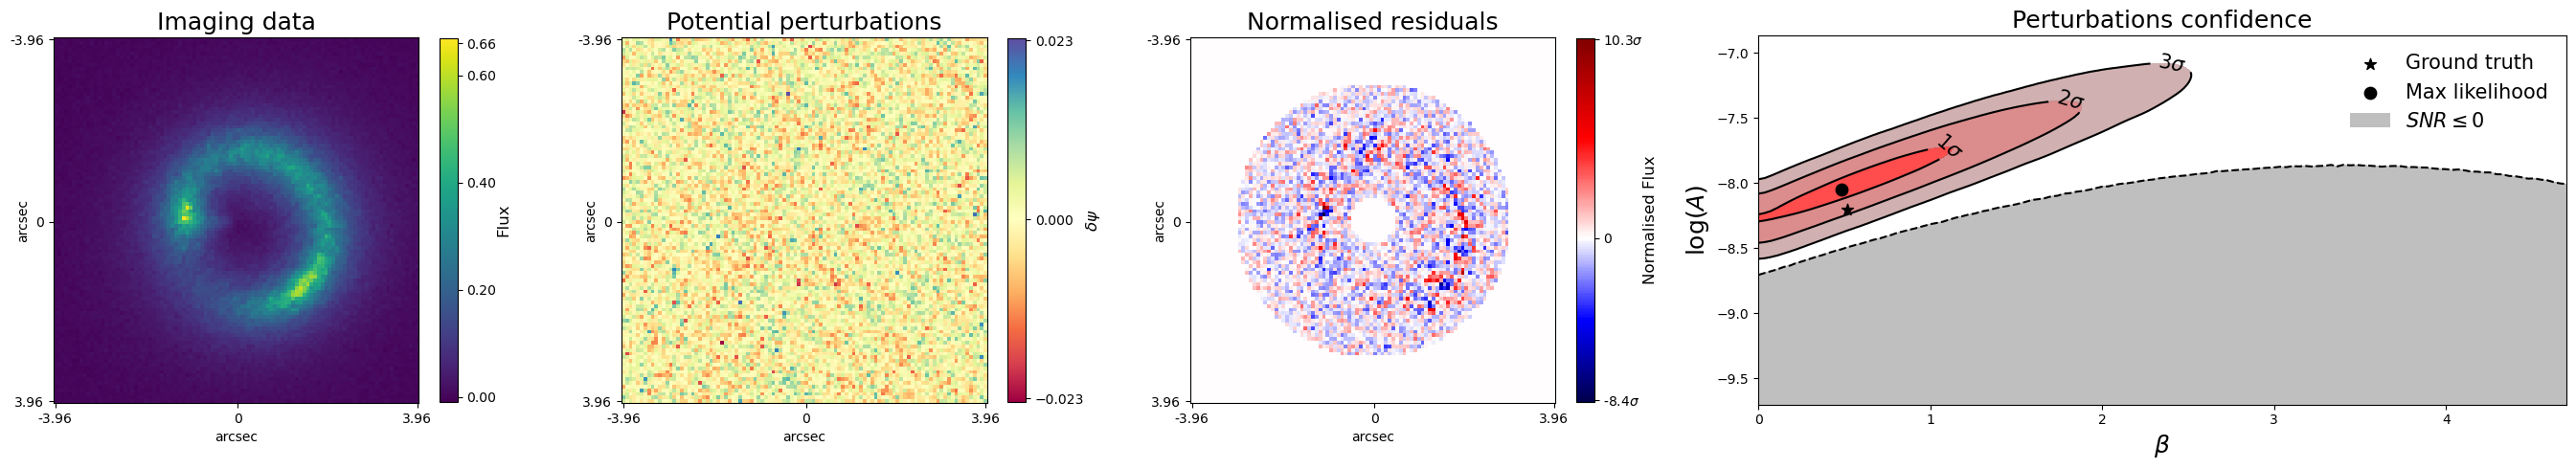

In [274]:
GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=\
    results_low_Beta


from matplotlib import gridspec
fig=plt.figure(figsize=(27,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1])
ax=[]
for i in range(1):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)

plot_line(ax[0],simulated_image,residuals,GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index,ylabel,\
          logA_ind_lim=(0,128),Beta_ind_lim=(0,128),legend_flag=True)

plt.tight_layout(h_pad=3,w_pad=2)

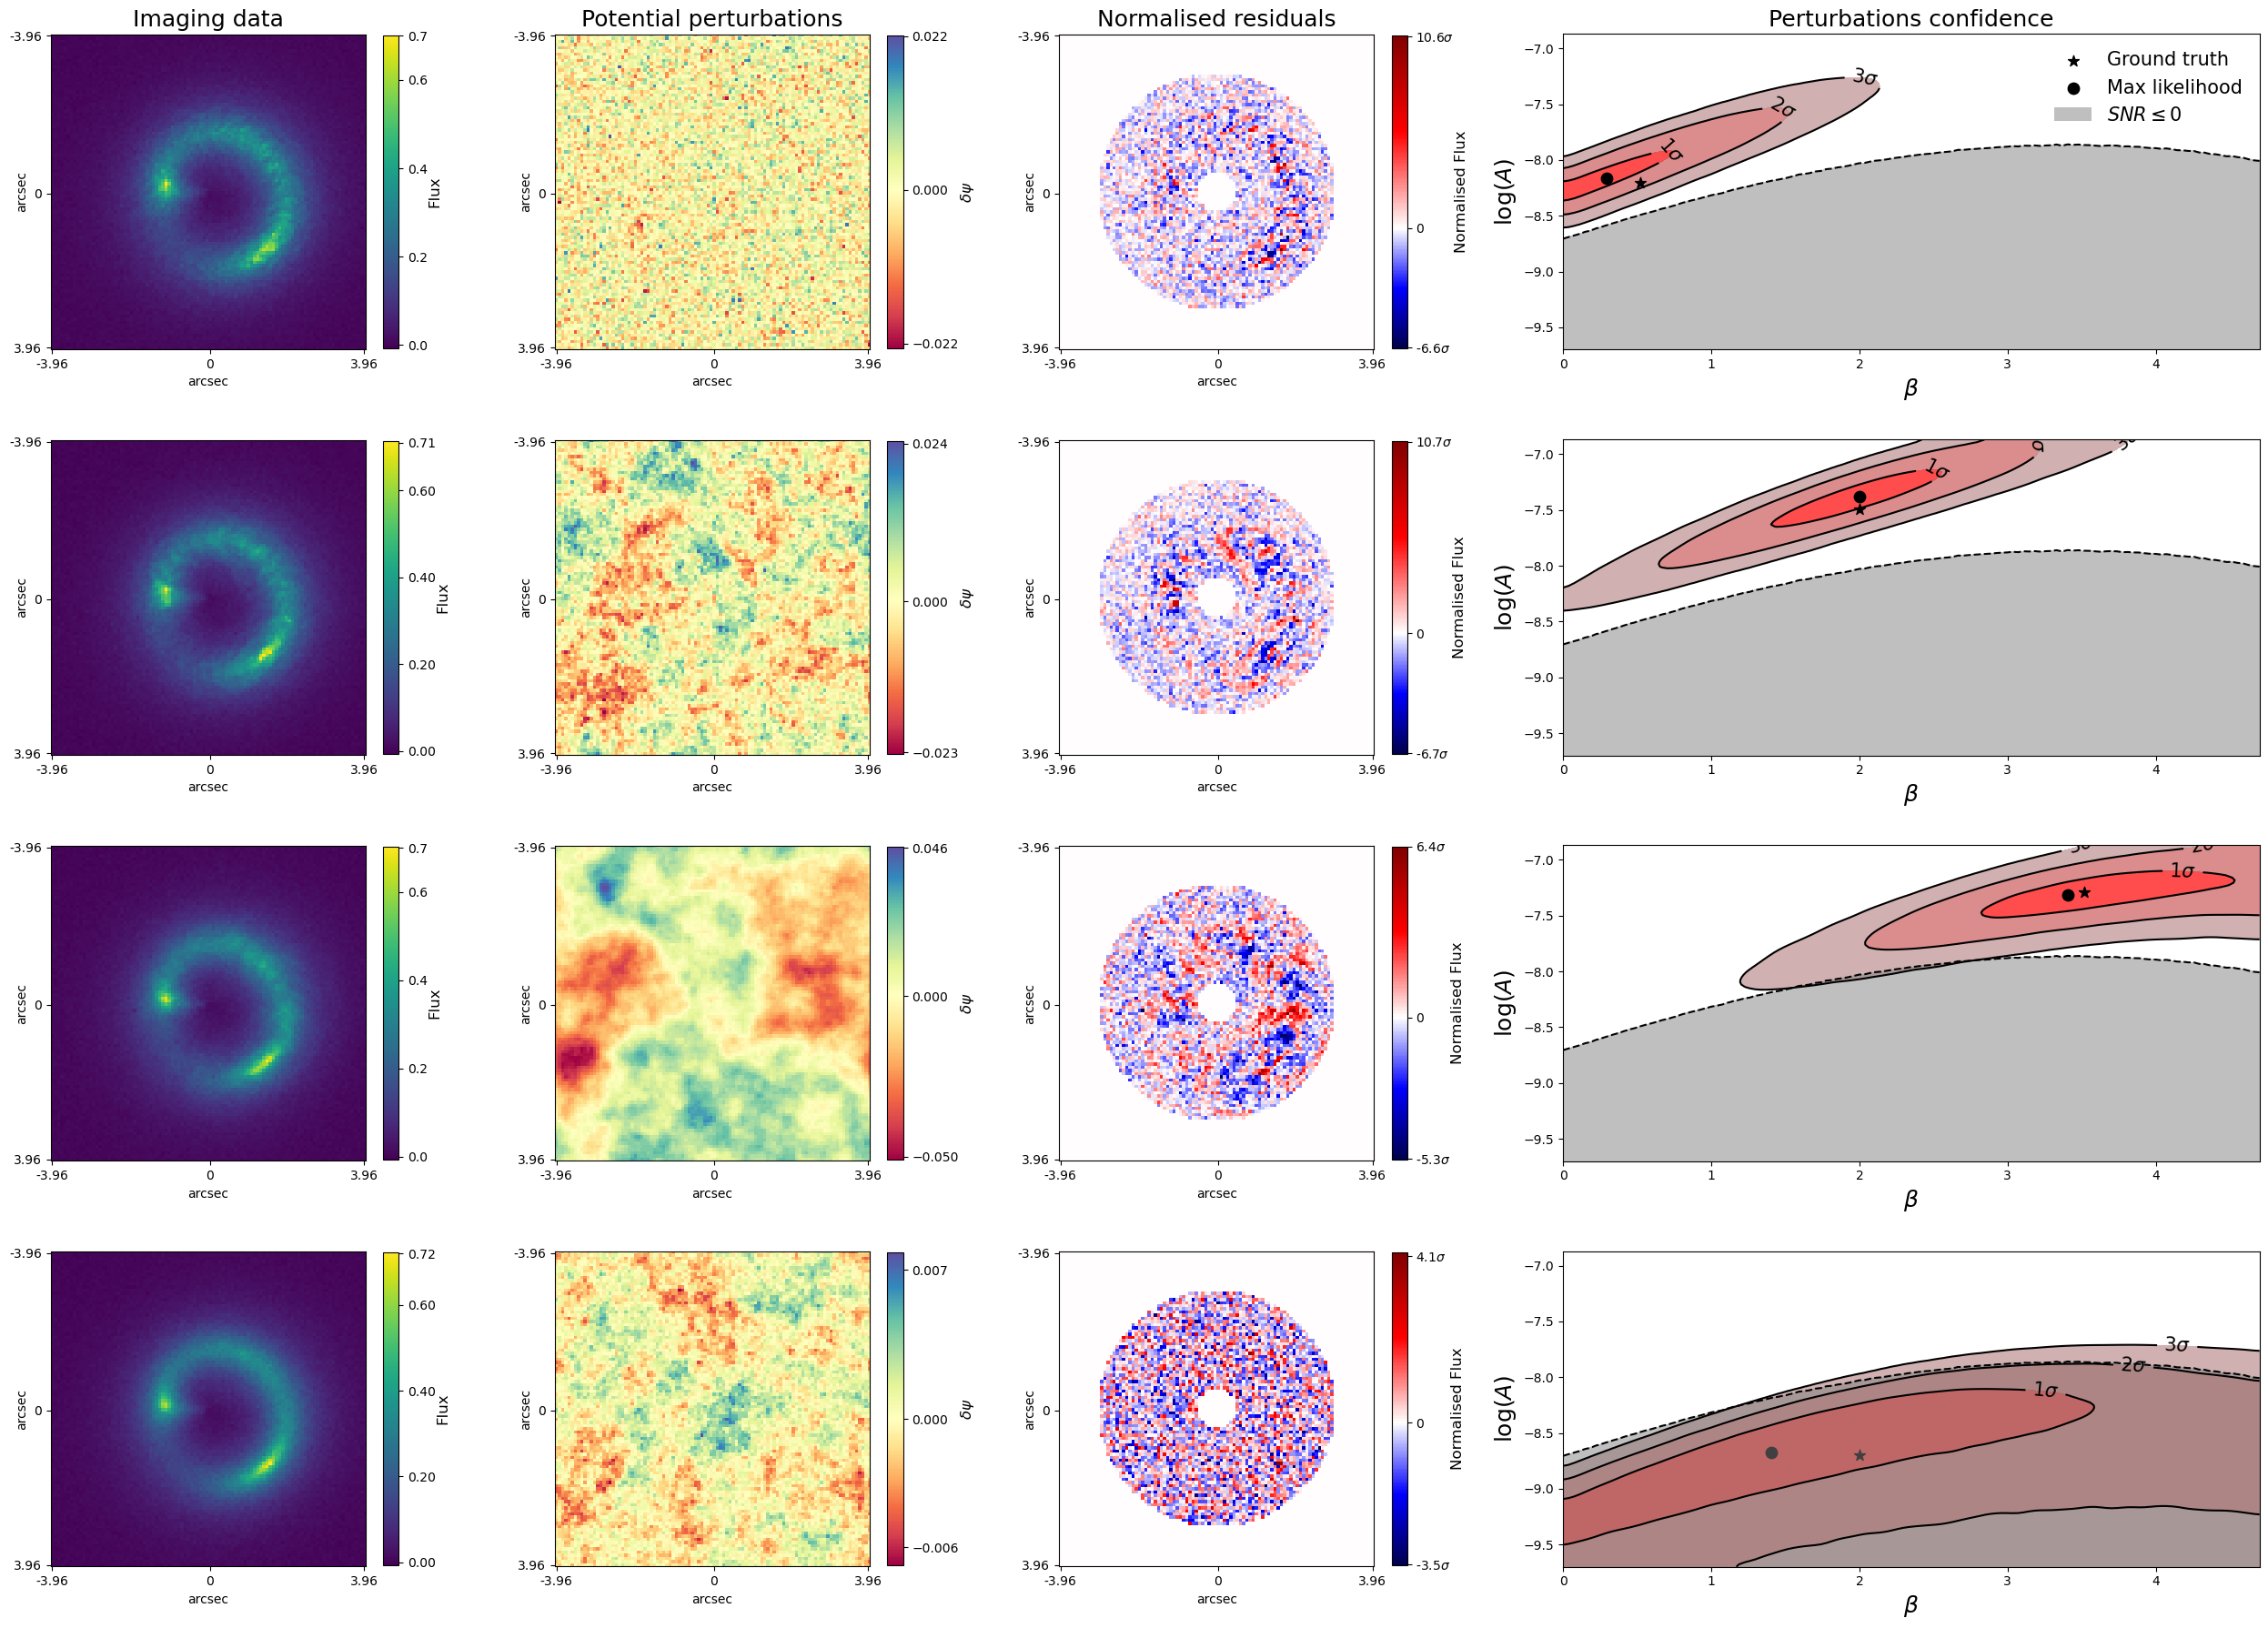

In [281]:
GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=results_high_Beta
from matplotlib import gridspec
fig=plt.figure(figsize=(25,18))
gs = gridspec.GridSpec(4, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1,1,1,1])
ax=[]
for i in range(4):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)

results_array=[results_low_Beta,results_high_SNR,results_high_Beta,results_low_SNR]

for i in range(4):
    GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,\
        pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=\
        results_array[i]
    
    if i==0:
        titles_flag=True
        legend_flag=True
    else:
        titles_flag=False
        legend_flag=False
    
    plot_line(ax[i],simulated_image,residuals,GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index,ylabel,\
          logA_ind_lim=(0,128),Beta_ind_lim=(0,128),legend_flag=legend_flag,titles_flag=titles_flag)

plt.tight_layout(h_pad=3,w_pad=2)

In [9]:
def compute_predictions_seeds(spectra_F_row,MU_tensor,Sigma_tensor):

    likelihoods=jax_map(lambda data_spectrum: get_likelihood(data_spectrum,MU_tensor,Sigma_tensor),spectra_F_row)

    res=jax_map(get_conf_intervals,likelihoods)

    return res

compute_Predictions_Betas= jax.jit(lambda spectra_BF_row: jax_map(lambda spectra_F_row: compute_predictions_seeds(spectra_F_row,MU_tensor,Sigma_tensor),spectra_BF_row))

In [7]:
from GRF_perturbations.Modules.Inference import get_likelihood
q=compute_predictions_seeds(Spectra_grid[0,0,:],MU_tensor,Sigma_tensor)

In [10]:
q=compute_Predictions_Betas(Spectra_grid[0,:2,:2])

In [11]:
q.shape

(2, 2, 7, 2)

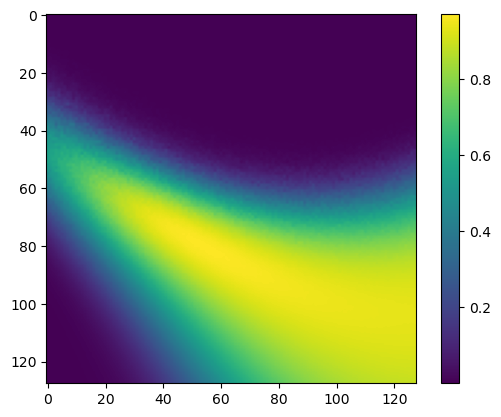

In [195]:
data_logSpectrum=np.log(Spectra_grid[80,50,0])
Loss_grid=jnp.mean(jnp.power((data_logSpectrum-MU_tensor)/Sigma_tensor,2),axis=-1)
plt.imshow(np.exp(-Loss_grid/2))
plt.colorbar()

In [192]:
from GRF_perturbations.Modules.Inference import compute_Confidence_grid
Confidence_grid=compute_Confidence_grid(np.exp(-Loss_grid/2))

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours+=[np.array(measure.find_contours(likelihood,isolevel))]


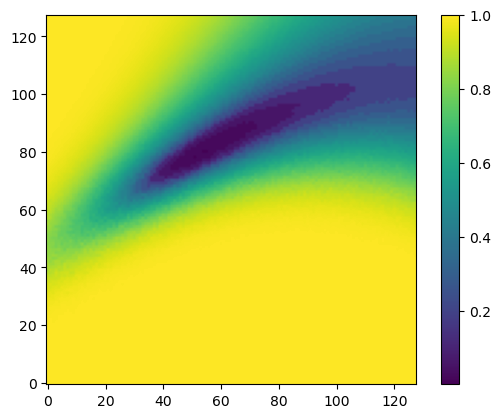

In [193]:
plt.imshow(Confidence_grid)
plt.gca().invert_yaxis()
plt.colorbar()

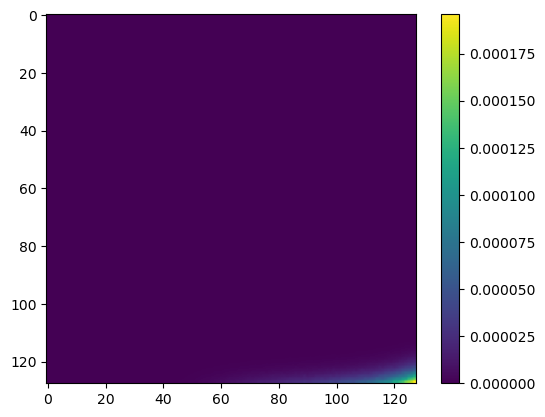

In [91]:
Loss_grid.shape

(128, 128)

In [65]:
MU_tensor.shape

(128, 128, 46)

In [69]:
q=np.log(Spectra_grid)-MU_tensor

ValueError: operands could not be broadcast together with shapes (128,128,100,46) (128,128,46) 

In [74]:
LN_gamma,LN_mu,LN_sigma=infer_LogNorm_params(Spectra_grid[0,0])

In [75]:
LN_sigma.shape

(46,)

# Inference test

In [18]:

y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

def set_labels_plt(fontsize):
    plt.gca().set_yticklabels(yticklabels,fontsize=fontsize)
    plt.gca().set_xticklabels(xticklabels,fontsize=fontsize)
    
def plot_line(ax_row,data_image,residuals_image,GRF_potential,likelihood,Confidence_grid,SNR,\
              true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,ylabel,\
              logA_ind_lim=(0,160),Beta_ind_lim=(0,214),legend_flag=True,titles_flag=True):
    #Data
    im=ax_row[0].imshow(data_image)
    cbar=fig.colorbar(im,ax=ax_row[0],ticks=[0,0.2,0.4,0.6,math.floor(data_image.max()*100)/100],fraction=0.045)
    cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)
    
    #Potential
    im=ax_row[1].imshow(GRF_potential,cmap='Spectral',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=fig.colorbar(im,ax=ax_row[1],ticks=[math.ceil(GRF_potential.min()*1e+3)/1e+3,0,math.floor(GRF_potential.max()*1e+3)/1e+3],fraction=0.045)
    cbar.ax.set_ylabel(r'$\delta \psi$',rotation=90,fontsize=12,labelpad=0)
    
    #masked_resid=resids_images[i]*mask
    #norm_masked_resid=(resids_images[i]/np.sqrt(noise_vars[i]))*mask
    
    #Residuals
    normalised_masked_residuals=(residuals_image*Observation_conditions.annulus_mask)/np.sqrt(noise_var)
    colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]
    
    im=ax[i,2].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=fig.colorbar(im,ax=ax_row[2],ticks=colorborders,fraction=0.045)
    cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
    cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    #fig.colorbar(im,ax=ax[i,2],ticks=[math.ceil(resids_images[i].min()*1e+3)/1e+3,0,math.floor(resids_images[i].max()*1e+3)/1e+3],fraction=0.045)
    
    
    Crop_Beta_arr=Beta_array[Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_logA_arr=logA_array[logA_ind_lim[0]:logA_ind_lim[1]]
    Crop_likelihood=likelihood[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_confidence=Confidence_grid[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_SNR=SNR[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    
    
    Like_xticks=np.arange(10)
    Like_xticks=Like_xticks[np.where( (Like_xticks>=Crop_Beta_arr[0]) & (Like_xticks<=Crop_Beta_arr[-1]) )[0]]
    Like_yticks=np.arange(0,8)*0.5-9.5
    Like_yticks=Like_yticks[np.where( (Like_yticks>=Crop_logA_arr[0]) & (Like_yticks<=Crop_logA_arr[-1]) )[0]]
    
    
    plot_likelihood(ax_row[3],Crop_Beta_arr,Crop_logA_arr,Crop_confidence,Crop_SNR,true_logA_index-logA_ind_lim[0],true_Beta_index-Beta_ind_lim[0],\
                    pred_logA_index-logA_ind_lim[0],pred_Beta_index-Beta_ind_lim[0],Like_xticks,Like_yticks,legend_flag)
    
    ra_at_xy_0,dec_at_xy_0=Observation_conditions.pixel_grid.radec_at_xy_0
    
    for j in range(3):
        ax_row[j].set_xticks([0,50,100-1])
        ax_row[j].set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0])
        ax_row[j].set_xlabel('arcsec')
        
        ax_row[j].set_yticks([0,50,100-1])
        ax_row[j].set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
        ax_row[j].set_ylabel('arcsec',labelpad=-15)
        '''
        if j!=0:
            ax_row[j].set_yticks([0,50,100-1])
            ax_row[j].set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
            ax_row[j].set_ylabel('arcsec',labelpad=-15)
        else:
            ax_row[j].set_yticks([])
            ax_row[j].set_ylabel('arcsec',labelpad=20)
        '''
        
    if titles_flag:
        titles=['Imaging data','Potential perturbations','Normalised residuals','Perturbations confidence']
        for j in range(4):
            ax_row[j].set_title(titles[j],fontsize=FS)
        
    '''
    box=ax_row[3].get_position()
    box.x0 = box.x0 + 0.02 
    ax_row[3].set_position(box)
    
    sup_ax=ax_row[0].twiny().twinx()
    sup_ax.yaxis.set_label_position('left')
    sup_ax.set_xticks([])
    
    sup_ax.yaxis.tick_left()
    #sup_ax.set_yticks([])
    sup_ax.set_yticks([0,50,100-1])
    sup_ax.set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
    #sup_ax.set_ylabel('arcsec',labelpad=-15)
    
    
    sup_ax.set_ylabel(ylabel,fontsize=FS,rotation=0)
    #sup_ax.set_ylabel(r"${\rm log}(A)$",fontsize=FS,rotation=0)
    sup_ax.yaxis.set_label_coords(-0.3,0.38)
    '''

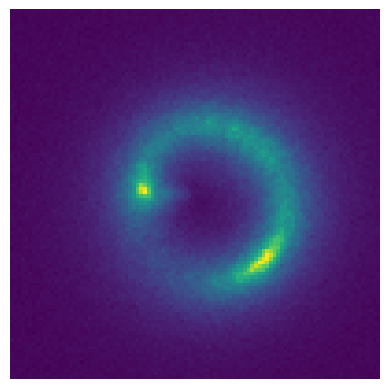

In [19]:
GRF_params=[-8.,2]
GRF_seed_index=1

get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,GRF_seed_index)

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

plt.imshow(simulated_image)
plt.axis('off')
plt.show()

In [20]:
results_low_SNR=conduct_inference([-8.7,2],1)

Uncertainties estimation took 0.0 seconds
Loss grid computation took 0.3 seconds
Confidence grid computation took 0.0 seconds


In [21]:
results_high_SNR=conduct_inference([-7.5,2],2)

Uncertainties estimation took 0.0 seconds
Loss grid computation took 0.3 seconds
Confidence grid computation took 0.0 seconds


In [22]:
results_low_Beta=conduct_inference([-8.21,0.5],3)

Uncertainties estimation took 0.0 seconds
Loss grid computation took 0.3 seconds
Confidence grid computation took 0.0 seconds


In [23]:
results_high_Beta=conduct_inference([-7.3,3.5],4)

Uncertainties estimation took 0.0 seconds
Loss grid computation took 0.3 seconds
Confidence grid computation took 0.0 seconds


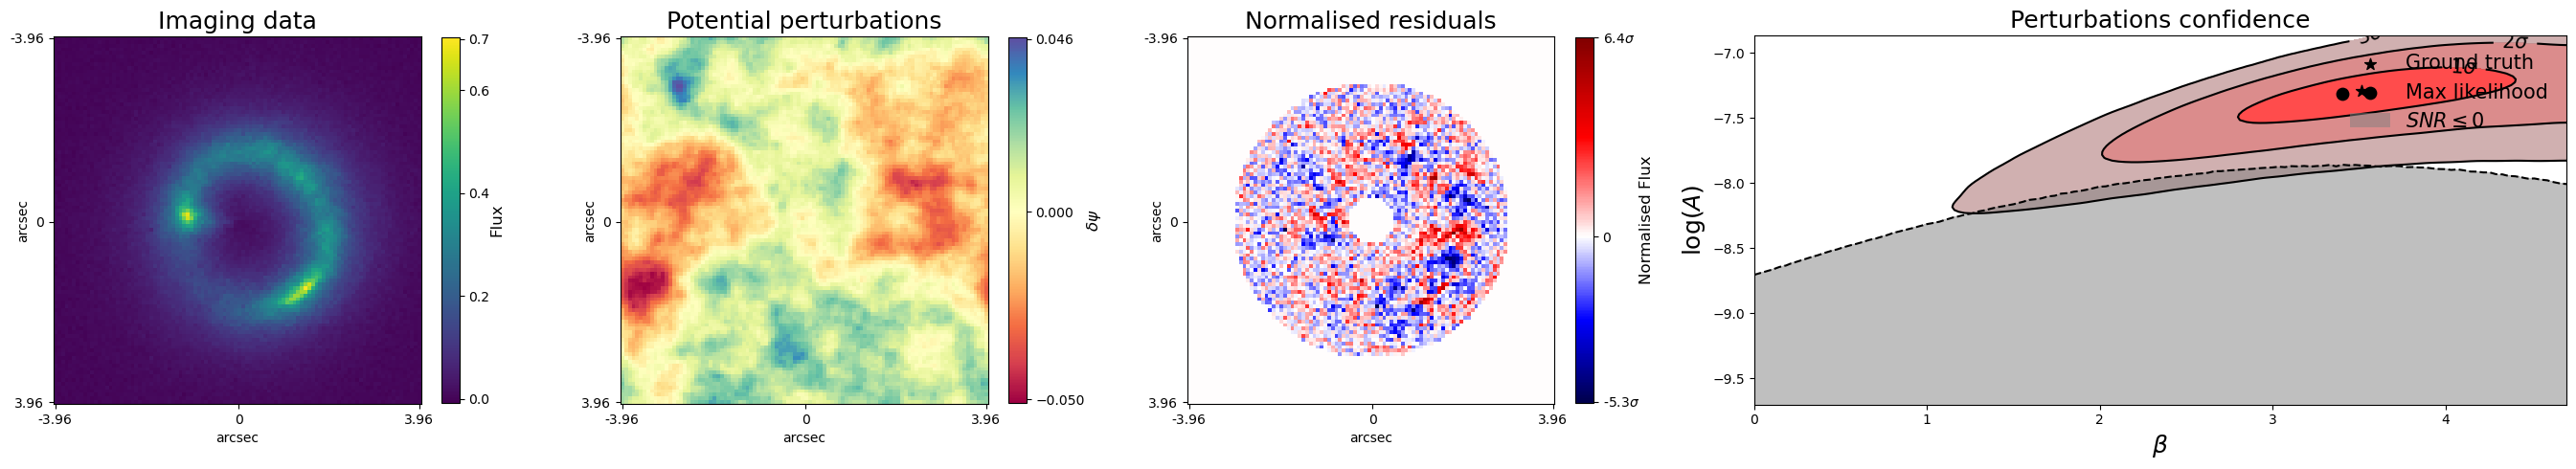

In [24]:
GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=results_high_Beta


from matplotlib import gridspec
fig=plt.figure(figsize=(27,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1])
ax=[]
for i in range(1):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)

plot_line(ax[0],simulated_image,residuals,GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index,ylabel,\
          logA_ind_lim=(0,128),Beta_ind_lim=(0,128),legend_flag=True)

plt.tight_layout(h_pad=3,w_pad=2)

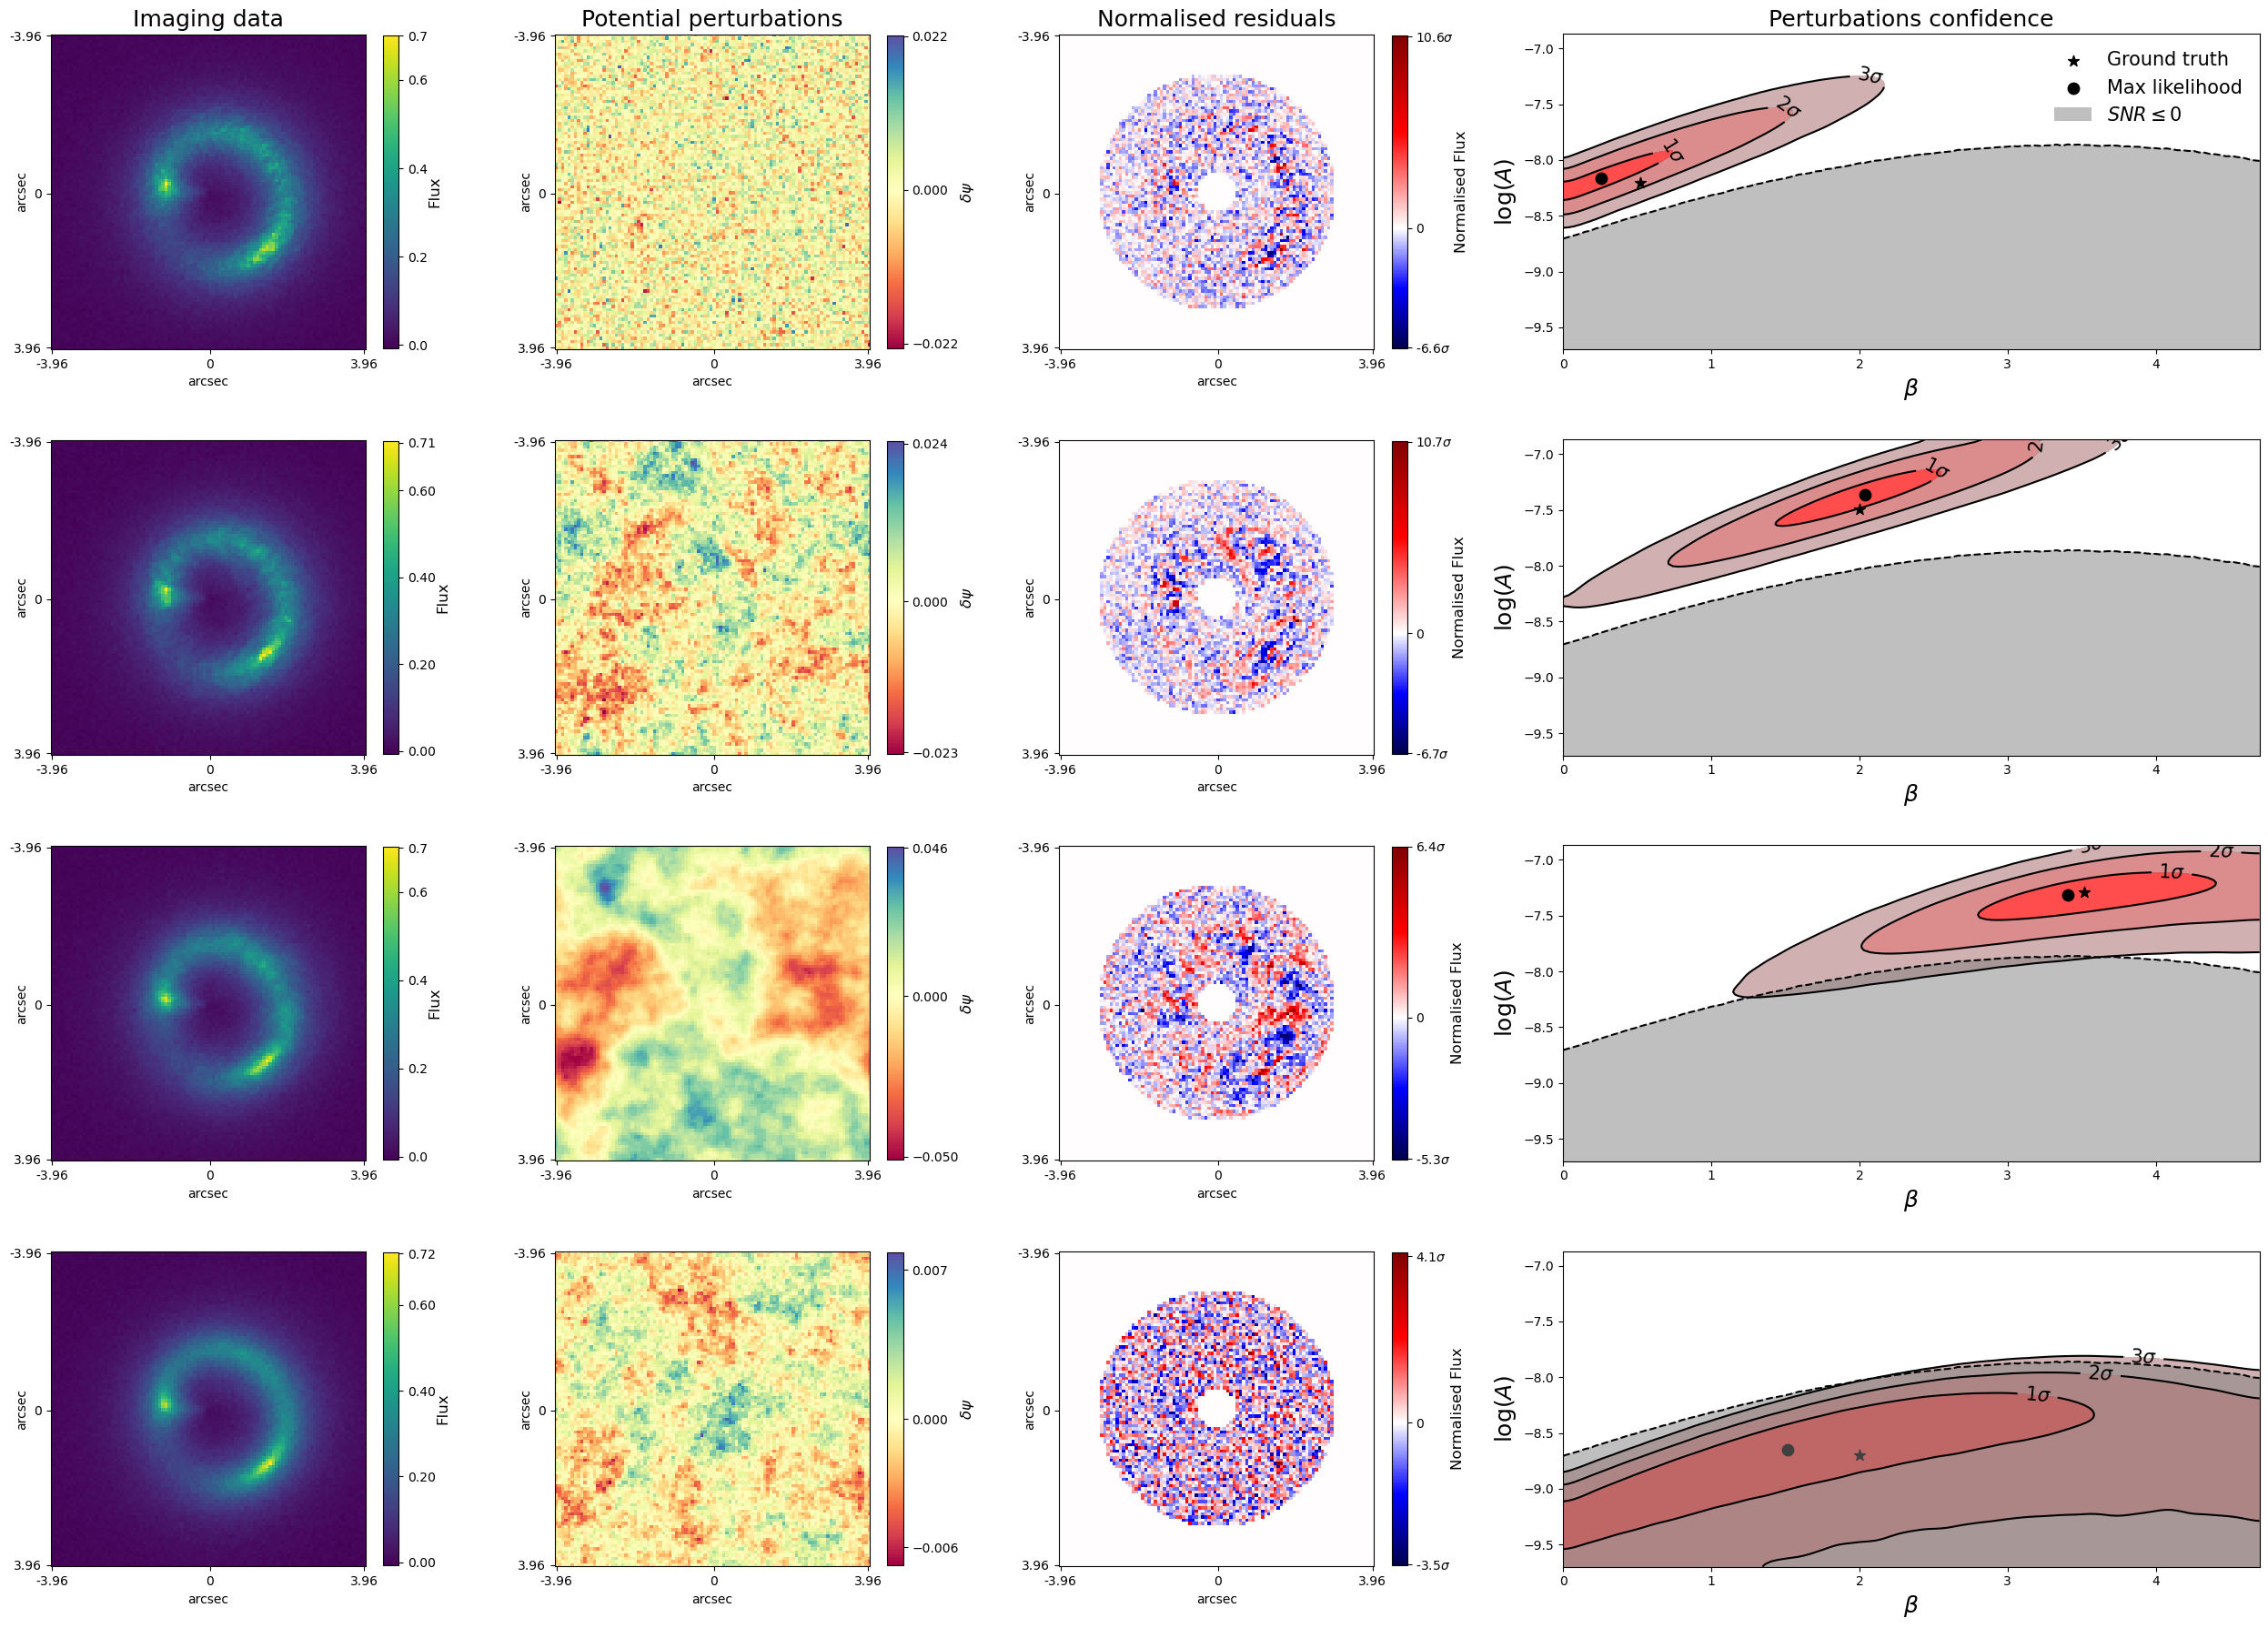

In [25]:
GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=results_high_Beta
from matplotlib import gridspec
fig=plt.figure(figsize=(25,18))
gs = gridspec.GridSpec(4, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1,1,1,1])
ax=[]
for i in range(4):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)

results_array=[results_low_Beta,results_high_SNR,results_high_Beta,results_low_SNR]

for i in range(4):
    GRF_potential,simulated_image,residuals,likelihood,Confidence_grid,\
        pred_logA_index,pred_Beta_index,true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index=\
        results_array[i]
    
    if i==0:
        titles_flag=True
        legend_flag=True
    else:
        titles_flag=False
        legend_flag=False
    
    plot_line(ax[i],simulated_image,residuals,GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index,ylabel,\
          logA_ind_lim=(0,128),Beta_ind_lim=(0,128),legend_flag=legend_flag,titles_flag=titles_flag)

plt.tight_layout(h_pad=3,w_pad=2)

In [ ]:
logA_array=np.linspace(-10.075,-6.9,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)

In [18]:
true_logA_index=np.argmin(np.abs(logA_array-GRF_params[0]))
true_Beta_index=np.argmin(np.abs(Beta_array-GRF_params[1]))

likelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(spectrum,Spectra_grid,true_logA_index,true_Beta_index)

Uncertainties estimation took 0.2 seconds
Loss grid computation took 0.3 seconds
Confidence grid computation took 0.0 seconds


/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:240: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours+=[np.array(measure.find_contours(likelihood,isolevel))]


In [19]:
gamma_data,mu_data,sigma_data=infer_LogNorm_params(Spectra_grid[true_logA_index,true_Beta_index])

Text(0.5, 1.0, 'Radial spectrum of Anomalies')

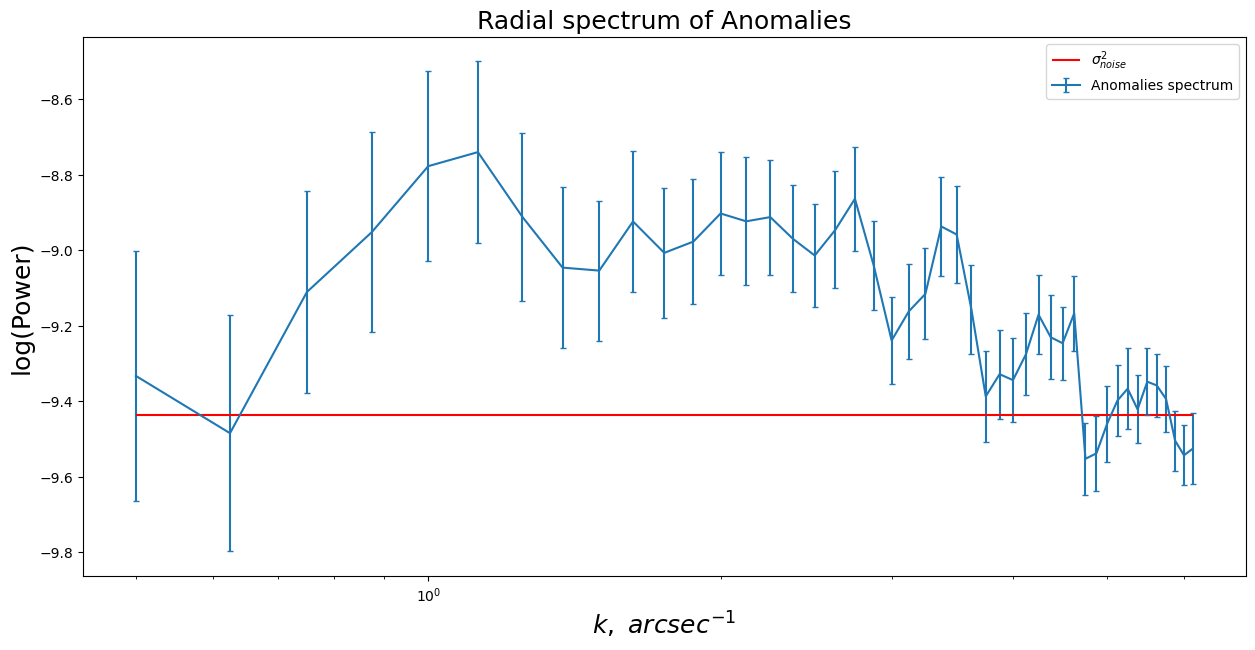

In [20]:
fig=plt.figure(figsize=(15,7))
plt.errorbar(Observation_conditions.frequencies,np.log(spectrum),sigma_data,capsize=2,label='Anomalies spectrum')
plt.hlines(np.log(Estimated_Noise_spectral_density),Observation_conditions.frequencies[0],Observation_conditions.frequencies[-1],color='r',label=r'$\sigma^2_{noise}$')
plt.xlabel(r'$k, \ arcsec^{-1}$',fontsize=FS)
plt.ylabel('log(Power)',fontsize=FS)
plt.xscale('log')
plt.legend()
plt.title('Radial spectrum of Anomalies',fontsize=FS)

In [252]:
'''from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as ndimage

g = sns.JointGrid(height=10)
#levels=np.linspace(0,likelihood.max(),21)

levels=np.linspace(0,(likelihood.max()*10).round()/10,21)
ct=g.ax_joint.contourf(Beta_array,logA_array,likelihood,levels, cmap='inferno')
#ct.collections[0].set_label('Likelihood')

#SNR constraint

img=g.ax_joint.contour(Beta_array,logA_array,SNR_grid,[0],colors='w',linestyles='--')
img.collections[0].set_label('SNR constraint')

fmt = {}
strs = ['SNR=0']
for l,s in zip( img.levels, strs ):
    fmt[l] = s

manual_locations=[(10,4)]
g.ax_joint.clabel(img,[0],inline=1,fontsize=15,fmt=fmt,manual=manual_locations)

#Prediction and truth


g.ax_joint.scatter(Beta_array[pred_Beta_index],logA_array[pred_logA_index],label='Predicted value',marker="o",s=80,color='k')
g.ax_joint.scatter(Beta_array[true_Beta_index],logA_array[true_logA_index],label='True value',marker="*",s=80,color='k')


#Marginalized Beta likelihood

Beta_likelihood=likelihood.mean(axis=0)

likelihood_color='C1'
g.ax_marg_x.plot(Beta_array,Beta_likelihood,color=likelihood_color,label='Likelihood')
g.ax_marg_x.fill_between(Beta_array,0,Beta_likelihood,alpha=0.5,color=likelihood_color)


g.ax_marg_x.vlines(Beta_array[pred_Beta_index],0,Beta_likelihood[pred_Beta_index],color='black',label='Pred value')
g.ax_marg_x.vlines(GRF_params[1],0,likelihood.mean(axis=0)[true_Beta_index],color='k',label='True value',linestyle='--')



g.ax_marg_x.legend(loc='upper right')

#Marginalized logA likelihood
logA_likelihood=likelihood.mean(axis=1)

g.ax_marg_y.plot(logA_likelihood,logA_array,color=likelihood_color,label='Likelihood')
g.ax_marg_y.fill_betweenx(logA_array,0,logA_likelihood,alpha=0.5,color=likelihood_color)

g.ax_marg_y.hlines(logA_array[pred_logA_index],0,logA_likelihood[pred_logA_index],color='black',label='Pred value')
g.ax_marg_y.hlines(GRF_params[0],0,logA_likelihood[true_logA_index],color='k',label='True value',linestyle='--')


g.ax_joint.set_xlabel('Beta',fontsize=FS)
#g.ax_joint.set_xlim(xlim[0],xlim[1])
g.ax_joint.set_ylabel('logA',fontsize=FS)
#g.ax_joint.set_ylim(ylim[0],ylim[1])

g.ax_joint.legend(loc='lower right')
#g.fig.suptitle('Loss='+r'$(\frac{data-model}{\sqrt{\sigma^2_{\sigma^2_{noise}}+\sigma^2_{binning}+\sigma^2_{phase}}})^2$',fontsize=FS,y=1.1)
g.fig.suptitle('Likelihood',fontsize=FS,y=1.,x=0.4)'''

'from mpl_toolkits.axes_grid1 import make_axes_locatable\nimport scipy.ndimage as ndimage\n\ng = sns.JointGrid(height=10)\n#levels=np.linspace(0,likelihood.max(),21)\n\nlevels=np.linspace(0,(likelihood.max()*10).round()/10,21)\nct=g.ax_joint.contourf(Beta_array,logA_array,likelihood,levels, cmap=\'inferno\')\n#ct.collections[0].set_label(\'Likelihood\')\n\n#SNR constraint\n\nimg=g.ax_joint.contour(Beta_array,logA_array,SNR_grid,[0],colors=\'w\',linestyles=\'--\')\nimg.collections[0].set_label(\'SNR constraint\')\n\nfmt = {}\nstrs = [\'SNR=0\']\nfor l,s in zip( img.levels, strs ):\n    fmt[l] = s\n\nmanual_locations=[(10,4)]\ng.ax_joint.clabel(img,[0],inline=1,fontsize=15,fmt=fmt,manual=manual_locations)\n\n#Prediction and truth\n\n\ng.ax_joint.scatter(Beta_array[pred_Beta_index],logA_array[pred_logA_index],label=\'Predicted value\',marker="o",s=80,color=\'k\')\ng.ax_joint.scatter(Beta_array[true_Beta_index],logA_array[true_logA_index],label=\'True value\',marker="*",s=80,color=\'k\')\n

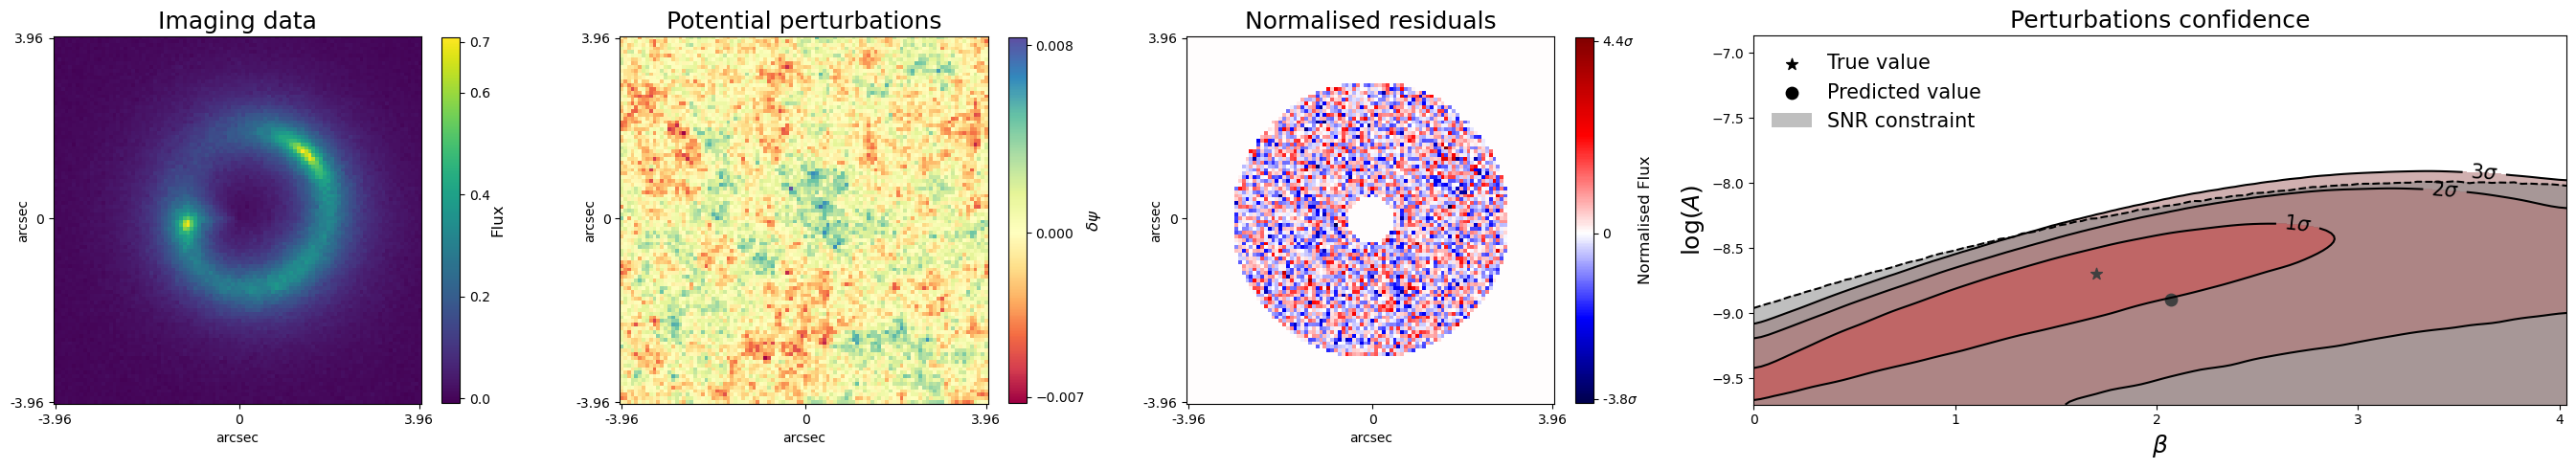

In [21]:
from matplotlib import gridspec
fig=plt.figure(figsize=(27,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1])
ax=[]
for i in range(1):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)

plot_line(ax[0],simulated_image,residuals,GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,ylabel,\
          logA_ind_lim=(0,128),Beta_ind_lim=(0,110),legend_flag=True)

plt.tight_layout(h_pad=3,w_pad=2)

In [81]:
pred_logA_index,pred_Beta_index,logA_conf_regions,Beta_conf_regions=get_conf_intervals(likelihood)

In [91]:
print('True logA={:.2f}'.format(GRF_params[0])+' Predicted logA={:.2f}'.format(logA_array[pred_logA_index]))
print('Confidence {:.2f} +{:.2f}'.format(*(logA_array[logA_conf_regions[0]]-logA_array[pred_logA_index])))

print('\nTrue Beta={:.2f}'.format(GRF_params[1])+' Predicted Beta={:.2f}'.format(Beta_array[pred_Beta_index]))
print('Confidence {:.2f} +{:.2f}'.format(*(Beta_array[Beta_conf_regions[0]]-Beta_array[pred_Beta_index])))

True logA=-7.50 Predicted logA=-7.54
Confidence -0.33 +0.27

True Beta=2.00 Predicted Beta=2.04
Confidence -0.63 +0.59


In [37]:
def get_cdf(likelihood):
    cdf=jnp.cumsum(likelihood)
    normalised_cdf=cdf/cdf[-1]

    return normalised_cdf

def get_prediction(cdf,pred_index,precentage_covered):
    #indent=np.minimum(0.5,percentage_covered/200.)
    indent=precentage_covered/200.

    upper_index=jnp.argmin(jnp.abs(cdf-cdf[pred_index]-indent))
    lower_index=jnp.argmin(jnp.abs(cdf-cdf[pred_index]+indent))

    return jnp.array([lower_index,upper_index])

def get_conf_intervals(likelihood):

    Beta_cdf=get_cdf(likelihood.mean(axis=0))
    Beta_pred_index=jnp.argmin(jnp.abs(Beta_cdf-0.5))


    logA_cdf=get_cdf(likelihood.mean(axis=1))
    logA_pred_index=jnp.argmin(jnp.abs(logA_cdf-0.5))

    percentage_covered=jnp.array([68,95,99.7])
    Beta_conf_regions=np.zeros((3,2))
    logA_conf_regions=np.zeros((3,2))

    
    Beta_conf_regions=jax_map(lambda percentage: get_prediction(Beta_cdf,Beta_pred_index,percentage),percentage_covered)
    logA_conf_regions=jax_map(lambda percentage: get_prediction(logA_cdf,logA_pred_index,percentage),percentage_covered)

    
    res_matrix=jnp.array([[logA_pred_index,Beta_pred_index]])
    res_matrix=jnp.append(res_matrix,logA_conf_regions,axis=0)
    res_matrix=jnp.append(res_matrix,Beta_conf_regions,axis=0)
    
    return res_matrix

def get_likelihood(data_spectrum,Spectra_grid,true_logA_index,true_Beta_index):
    
    logdata_spectrum=jnp.log(data_spectrum)
    gamma_data,mu_data,sigma_data=infer_LogNorm_params(Spectra_grid[true_logA_index,true_Beta_index])
    
    Spectra_Loss_pure=lambda model_spectra: Spectra_Loss(model_spectra,logdata_spectrum,sigma_data)
    i
    Loss_grid=compute_Loss_grid(Spectra_grid,Spectra_Loss_pure)
    likelihood=jnp.exp(-Loss_grid/2)
    
    return likelihood

In [38]:
def compute_predictions_seeds(true_logA_index,true_Beta_index,Spectra_grid):
    
    data_spectra=Spectra_grid[true_logA_index,true_Beta_index]
    
    likelihoods=jax_map(lambda data_spectrum: get_likelihood(data_spectrum,Spectra_grid,true_logA_index,true_Beta_index),data_spectra)
    
    res=jax_map(get_conf_intervals,likelihoods)
    
    return res 

# Metaanalysis

In [12]:
Prediction_grid=np.load('../Processing_scripts/results/prediction/Predictions_grid_node_0.npz')['arr_0']

for i in range(1,4):
    Prediction_grid=np.append(Prediction_grid,np.load('../Processing_scripts/results/prediction/Predictions_grid_node_{}.npz'.format(i))['arr_0'],axis=0)

In [11]:
'''Prediction_grid=np.load('../Processing_scripts/results/prediction/Predictions_grid_node_0.npz')['arr_0']

for i in range(1,4):
    Prediction_grid=np.append(Prediction_grid,np.load('../Processing_scripts/results/prediction/Predictions_grid_node_{}.npz'.format(i))['arr_0'],axis=0)'''

In [13]:
predicted_indices=Prediction_grid[:,:,:,0]
logA_confidence_regions=Prediction_grid[:,:,:,1:4]
Beta_confidence_regions=Prediction_grid[:,:,:,4:]

In [14]:
true_indices=np.array([np.arange(0,len(logA_array)),np.arange(0,len(Beta_array))])

In [15]:
predicted_bias=np.zeros((len(logA_array),len(Beta_array),100,2))

uncertainty_width=np.zeros((len(logA_array),len(Beta_array),100,2,3))


average_prediction=predicted_indices.mean(axis=-2)
for i in range(len(logA_array)):
    for j in range(len(Beta_array)):
        
        logA_uncertainty_width=logA_confidence_regions[i,j,:,:,1]-logA_confidence_regions[i,j,:,:,0]
        Beta_uncertainty_width=Beta_confidence_regions[i,j,:,:,1]-Beta_confidence_regions[i,j,:,:,0]
        
        uncertainty_width[i,j,:,0,:]=logA_uncertainty_width
        uncertainty_width[i,j,:,1,:]=Beta_uncertainty_width
        
        predicted_bias[i,j,:,0]=(predicted_indices[i,j,:,0]-true_indices[0][i])
        predicted_bias[i,j,:,1]=(predicted_indices[i,j,:,1]-true_indices[1][j])
        

mean_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).mean(axis=-2)

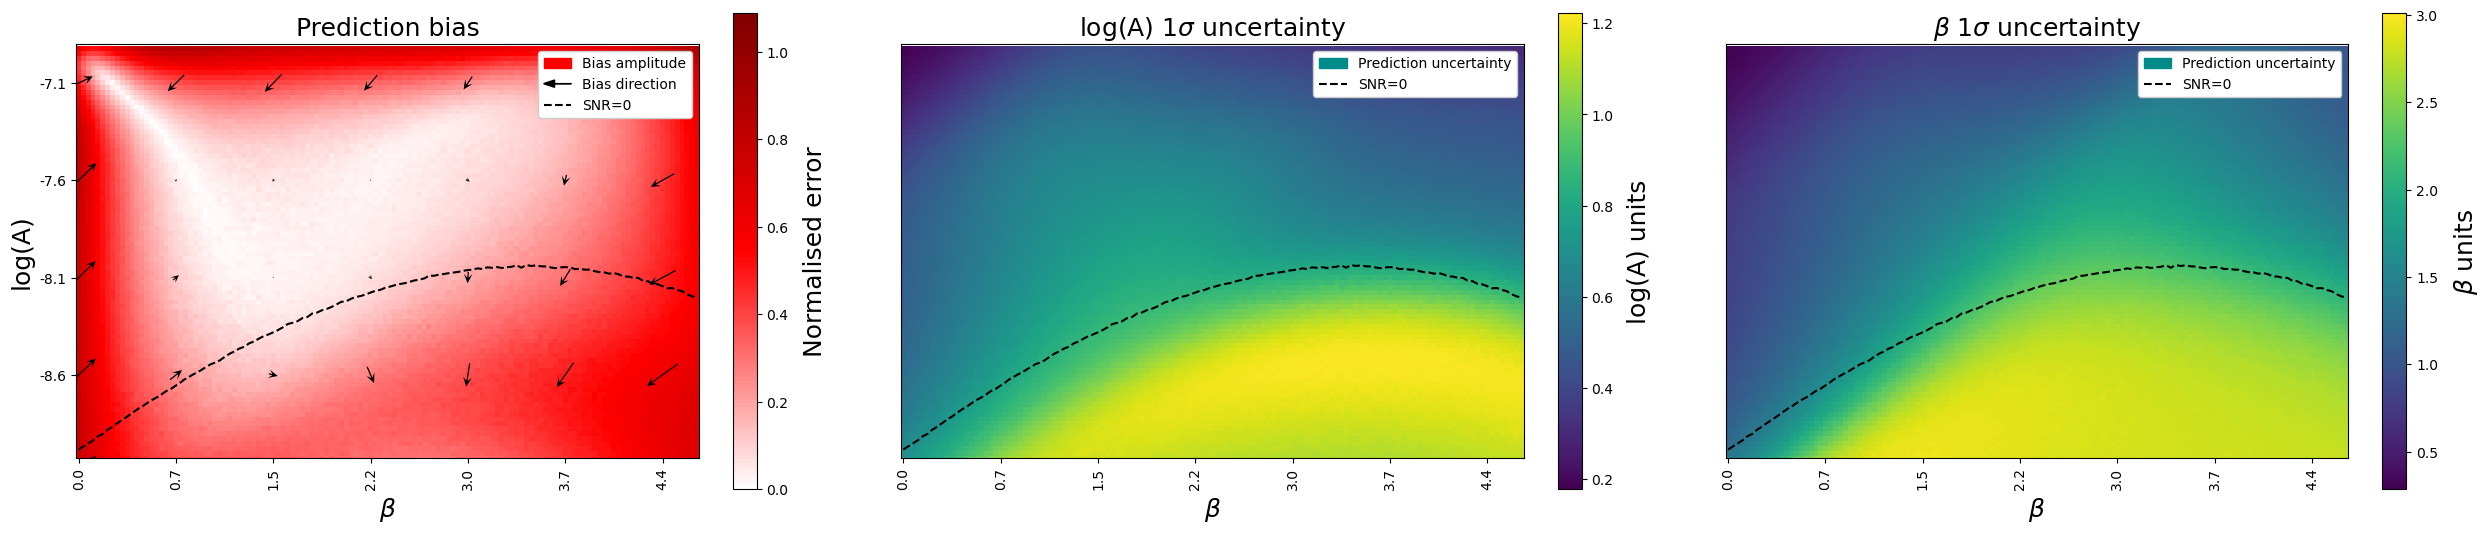

In [27]:
fig,ax=plt.subplots(1,3,figsize=(25,7))

#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

X,Y=np.meshgrid(np.arange(len(Beta_array)),np.arange(len(logA_array)))
I=mean_bias[:,:,1]
J=mean_bias[:,:,0]


#Quiver
step=20
imgquiver=ax[0].quiver(X[::step,::step],Y[::step,::step],I[::step,::step], J[::step,::step],scale=10,width=0.002,headwidth=7,headlength=7.5,pivot='middle',label='Bias direction')

#SNR contour
imgSNR=ax[0].contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')

red_patch = mpatches.Patch(color='red', label='The red data')
imgarr=ax[0].arrow(0,0,0,0,color='k',alpha=1)

def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(width, 0.5*height, -width, 0, length_includes_head=True, head_width=0.75*height )
    return p

ax[0].legend([red_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
           handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='upper right',framealpha=1,facecolor='w')

#Bias amplitude
img_arr=[]
img_arr+=[ax[0].imshow(np.sqrt(I**2+J**2),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]


sigma=1
mean_uncert=uncertainty_width.mean(axis=2)

img_arr+=[ax[1].imshow(mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[2].imshow(mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]

titles=['Prediction bias','log(A) '+str(sigma)+r'$\sigma$'+' uncertainty',r'$\beta$ '+str(sigma)+r'$\sigma$'+' uncertainty']
units=['Normalised error','log(A) units',r'$\beta$'+' units']


for i in range(3):

    ax[i].invert_yaxis()

    labelstep=20
    if i==0:
        ax[i].set_yticks(np.arange(0,len(logA_array),labelstep))
        ax[i].set_yticklabels(logA_array[::labelstep].round(1))
        ax[i].set_ylabel('log(A)',fontsize=FS)
        ax[i].legend([red_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
           handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='upper right',framealpha=1,facecolor='w')
    else:
        ax[i].set_yticks([])
        imgSNR=ax[i].contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')
        blue_patch = mpatches.Patch(color='darkcyan', label='The blue data')
        ax[i].legend([blue_patch,imgSNR.collections[0]], ['Prediction uncertainty','SNR=0'],loc='upper right',framealpha=1,facecolor='w')
        #l=ax[i].legend(loc='upper right',framealpha=1,facecolor='w')
    
    ax[i].set_xticks(np.arange(0,len(Beta_array),labelstep))
    ax[i].set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)


    ax[i].set_title(titles[i],fontsize=FS)
    cbar=plt.colorbar(img_arr[i],ax=ax[i],fraction=0.035)
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=10)
    
    ax[i].set_ylim(np.argmin(np.abs(logA_array-(-9))),128)

fig.tight_layout(w_pad=5)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_33219/2198496230.py:27: UserWarning: The following kwargs were not used by contour: 'label'
  img_arr+=[ax[0].contourf(X,Y,np.sqrt(I**2+J**2),10,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]


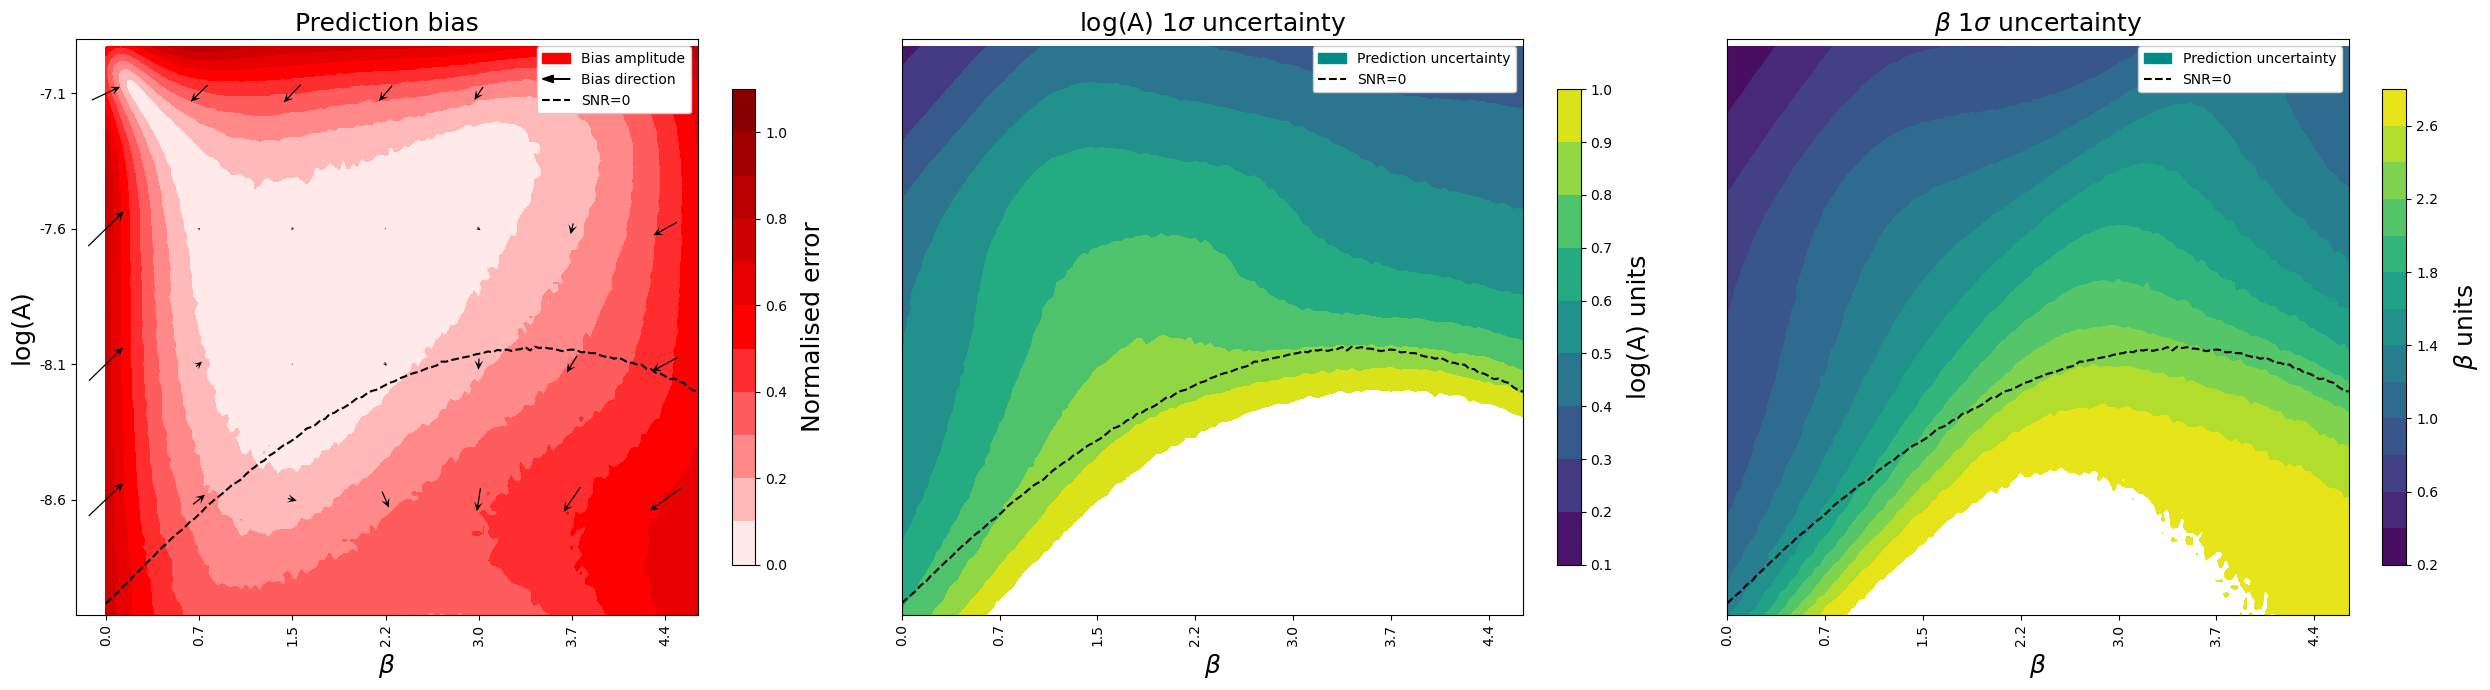

In [30]:
fig,ax=plt.subplots(1,3,figsize=(25,7))

#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

X,Y=np.meshgrid(np.arange(len(Beta_array)),np.arange(len(logA_array)))
I=mean_bias[:,:,1]
J=mean_bias[:,:,0]




def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(width, 0.5*height, -width, 0, length_includes_head=True, head_width=0.75*height )
    return p

ax[0].legend([red_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
           handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='upper right',framealpha=1,facecolor='w')

#Bias amplitude
img_arr=[]
#img_arr+=[ax[0].imshow(np.sqrt(I**2+J**2),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]
img_arr+=[ax[0].contourf(X,Y,np.sqrt(I**2+J**2),10,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]


#Quiver
step=20
imgquiver=ax[0].quiver(X[::step,::step],Y[::step,::step],I[::step,::step], J[::step,::step],scale=10,width=0.002,headwidth=7,headlength=7.5,pivot='middle',label='Bias direction')

#SNR contour
imgSNR=ax[0].contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')

red_patch = mpatches.Patch(color='red', label='The red data')
imgarr=ax[0].arrow(0,0,0,0,color='k',alpha=1)


sigma=1
mean_uncert=uncertainty_width.mean(axis=2)

#img_arr+=[ax[1].imshow(mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].contourf(X,Y,mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]),levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])]
#img_arr+=[ax[2].imshow(mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]
img_arr+=[ax[2].contourf(X,Y,mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]),levels=[0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8])]

titles=['Prediction bias','log(A) '+str(sigma)+r'$\sigma$'+' uncertainty',r'$\beta$ '+str(sigma)+r'$\sigma$'+' uncertainty']
units=['Normalised error','log(A) units',r'$\beta$'+' units']


for i in range(3):

    ax[i].invert_yaxis()

    labelstep=20
    if i==0:
        ax[i].set_yticks(np.arange(0,len(logA_array),labelstep))
        ax[i].set_yticklabels(logA_array[::labelstep].round(1))
        ax[i].set_ylabel('log(A)',fontsize=FS)
        ax[i].legend([red_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
           handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='upper right',framealpha=1,facecolor='w')
    else:
        ax[i].set_yticks([])
        imgSNR=ax[i].contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')
        blue_patch = mpatches.Patch(color='darkcyan', label='The blue data')
        ax[i].legend([blue_patch,imgSNR.collections[0]], ['Prediction uncertainty','SNR=0'],loc='upper right',framealpha=1,facecolor='w')
        #l=ax[i].legend(loc='upper right',framealpha=1,facecolor='w')
    
    ax[i].set_xticks(np.arange(0,len(Beta_array),labelstep))
    ax[i].set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)


    ax[i].set_title(titles[i],fontsize=FS)
    cbar=plt.colorbar(img_arr[i],ax=ax[i],fraction=0.035)
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=10)
    
    ax[i].set_ylim(np.argmin(np.abs(logA_array-(-9))),128)

fig.tight_layout(w_pad=5)

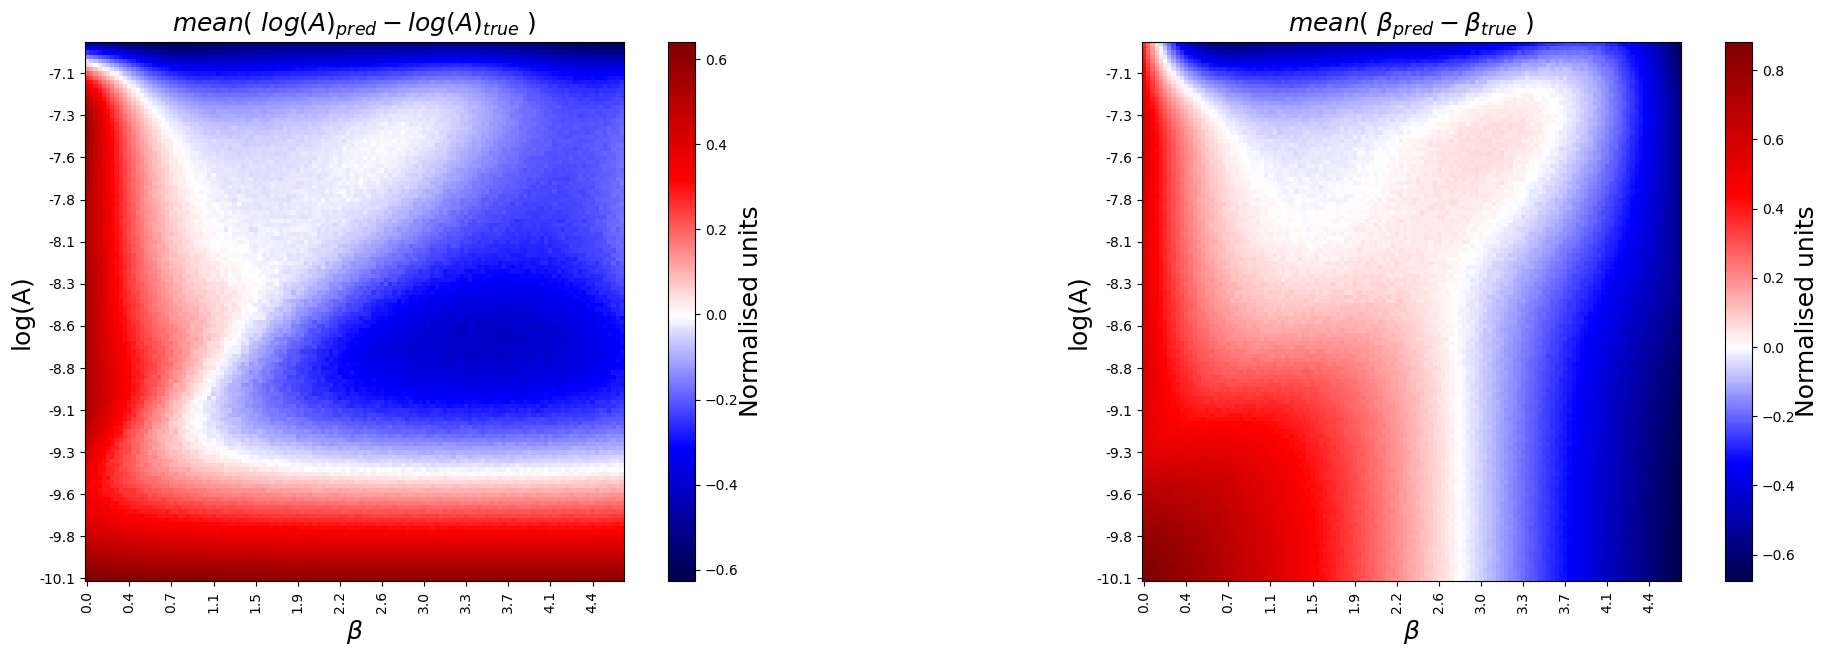

In [28]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

img_arr+=[ax[0].imshow(mean_bias[:,:,0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
img_arr+=[ax[1].imshow(mean_bias[:,:,1],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=[r'$mean( \ log(A)_{pred}-log(A)_{true} \ )$',r'$mean( \ \beta_{pred}-\beta_{true} \ )$']
units=['Normalised units','Normalised units']

for i in range(2):
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(0,len(logA_array),10))
    ax[i].set_yticklabels(logA_array[::10].round(1))
    
    ax[i].set_xticks(np.arange(0,len(Beta_array),10))
    ax[i].set_xticklabels(Beta_array[::10].round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

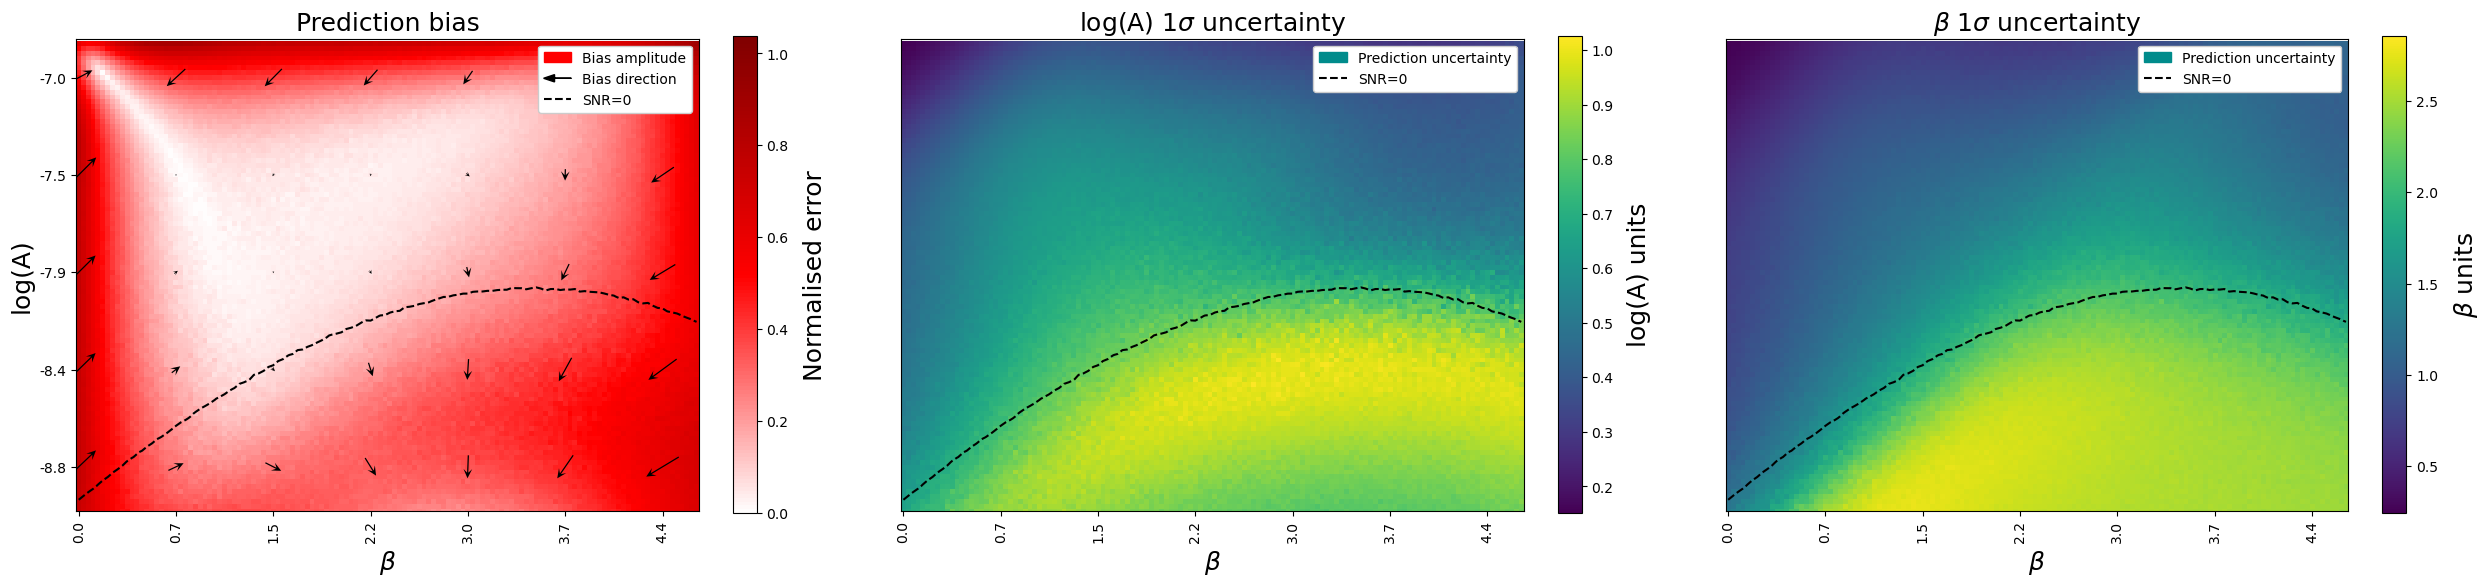

In [15]:
fig,ax=plt.subplots(1,3,figsize=(25,7))

#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

X,Y=np.meshgrid(np.arange(len(Beta_array)),np.arange(len(logA_array)))
I=mean_bias[:,:,1]
J=mean_bias[:,:,0]


#Quiver
step=20
imgquiver=ax[0].quiver(X[::step,::step],Y[::step,::step],I[::step,::step], J[::step,::step],scale=10,width=0.002,headwidth=7,headlength=7.5,pivot='middle',label='Bias direction')

#SNR contour
imgSNR=ax[0].contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')

red_patch = mpatches.Patch(color='red', label='The red data')
imgarr=ax[0].arrow(0,0,0,0,color='k',alpha=1)

def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(width, 0.5*height, -width, 0, length_includes_head=True, head_width=0.75*height )
    return p

ax[0].legend([red_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
           handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='upper right',framealpha=1,facecolor='w')

#Bias amplitude
img_arr=[]
img_arr+=[ax[0].imshow(np.sqrt(I**2+J**2),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]


sigma=1
mean_uncert=uncertainty_width.mean(axis=2)

img_arr+=[ax[1].imshow(mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[2].imshow(mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]

titles=['Prediction bias','log(A) '+str(sigma)+r'$\sigma$'+' uncertainty',r'$\beta$ '+str(sigma)+r'$\sigma$'+' uncertainty']
units=['Normalised error','log(A) units',r'$\beta$'+' units']


for i in range(3):

    ax[i].invert_yaxis()

    labelstep=20
    if i==0:
        ax[i].set_yticks(np.arange(0,len(logA_array),labelstep))
        ax[i].set_yticklabels(logA_array[::labelstep].round(1))
        ax[i].set_ylabel('log(A)',fontsize=FS)
        ax[i].legend([red_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
           handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='upper right',framealpha=1,facecolor='w')
    else:
        ax[i].set_yticks([])
        imgSNR=ax[i].contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')
        blue_patch = mpatches.Patch(color='darkcyan', label='The blue data')
        ax[i].legend([blue_patch,imgSNR.collections[0]], ['Prediction uncertainty','SNR=0'],loc='upper right',framealpha=1,facecolor='w')
        #l=ax[i].legend(loc='upper right',framealpha=1,facecolor='w')
    
    ax[i].set_xticks(np.arange(0,len(Beta_array),labelstep))
    ax[i].set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)


    ax[i].set_title(titles[i],fontsize=FS)
    cbar=plt.colorbar(img_arr[i],ax=ax[i],fraction=0.035)
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=10)
    
    ax[i].set_ylim(np.argmin(np.abs(logA_array-(-9))),128)

fig.tight_layout(w_pad=5)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_33219/2198496230.py:27: UserWarning: The following kwargs were not used by contour: 'label'
  img_arr+=[ax[0].contourf(X,Y,np.sqrt(I**2+J**2),10,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]


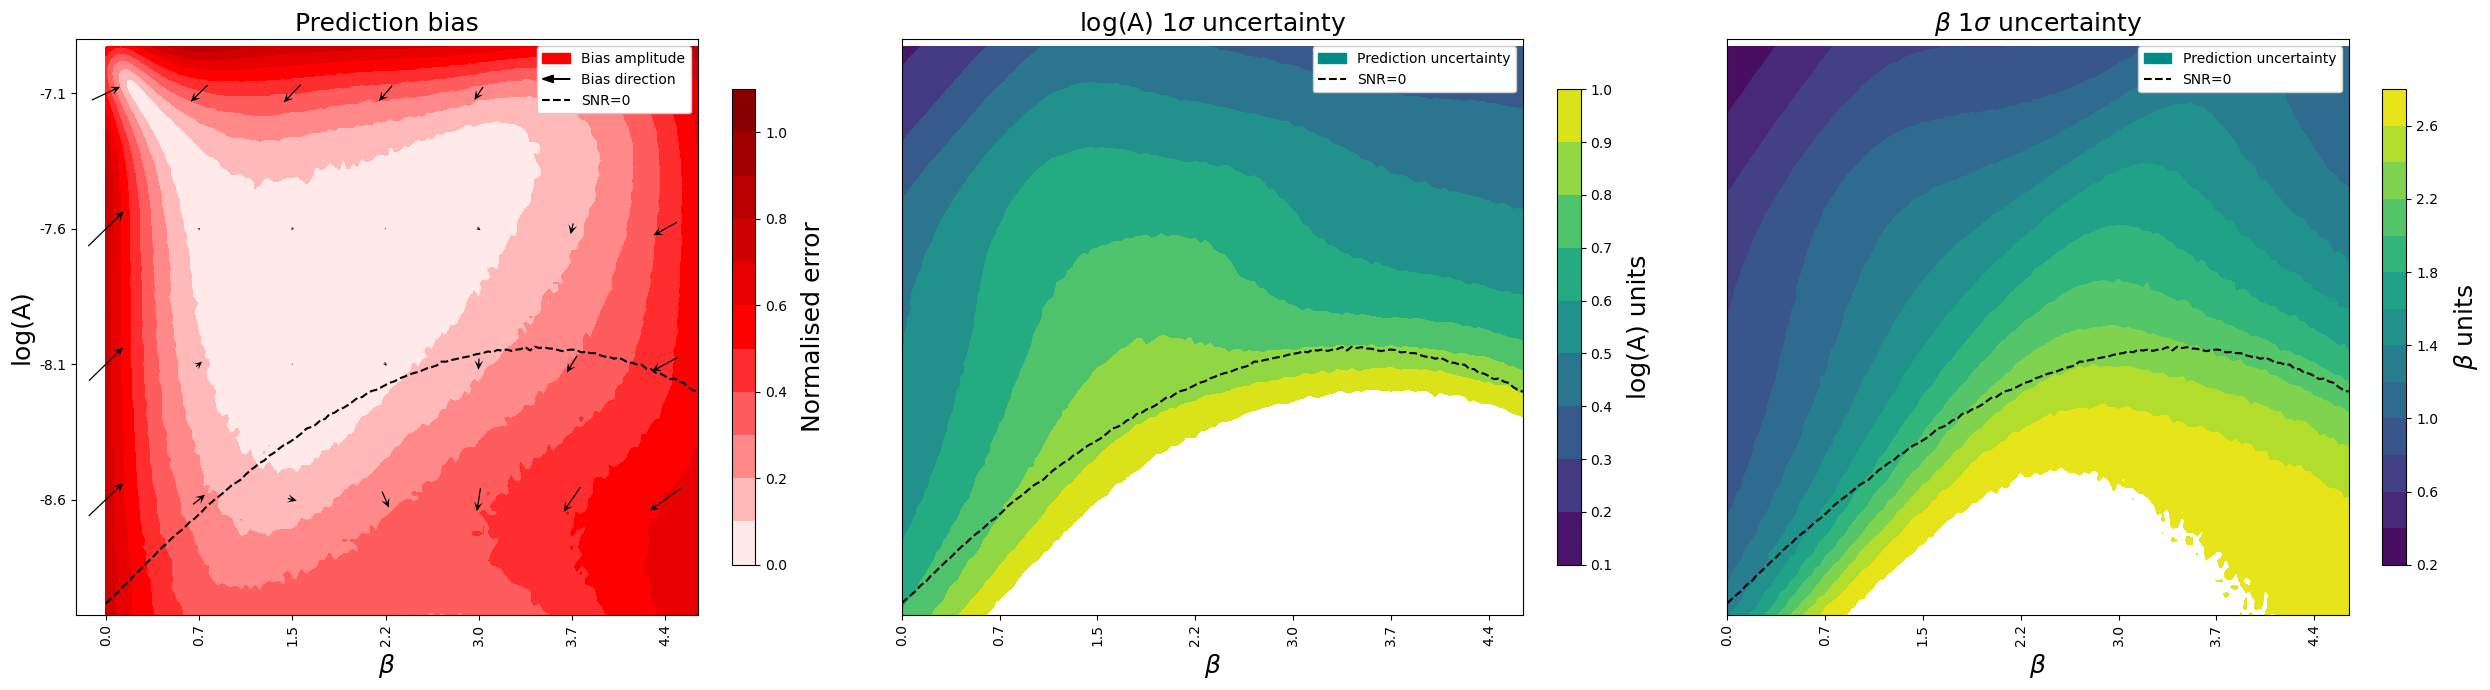

In [68]:
np.arange(30)/5

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
       5.2, 5.4, 5.6, 5.8])

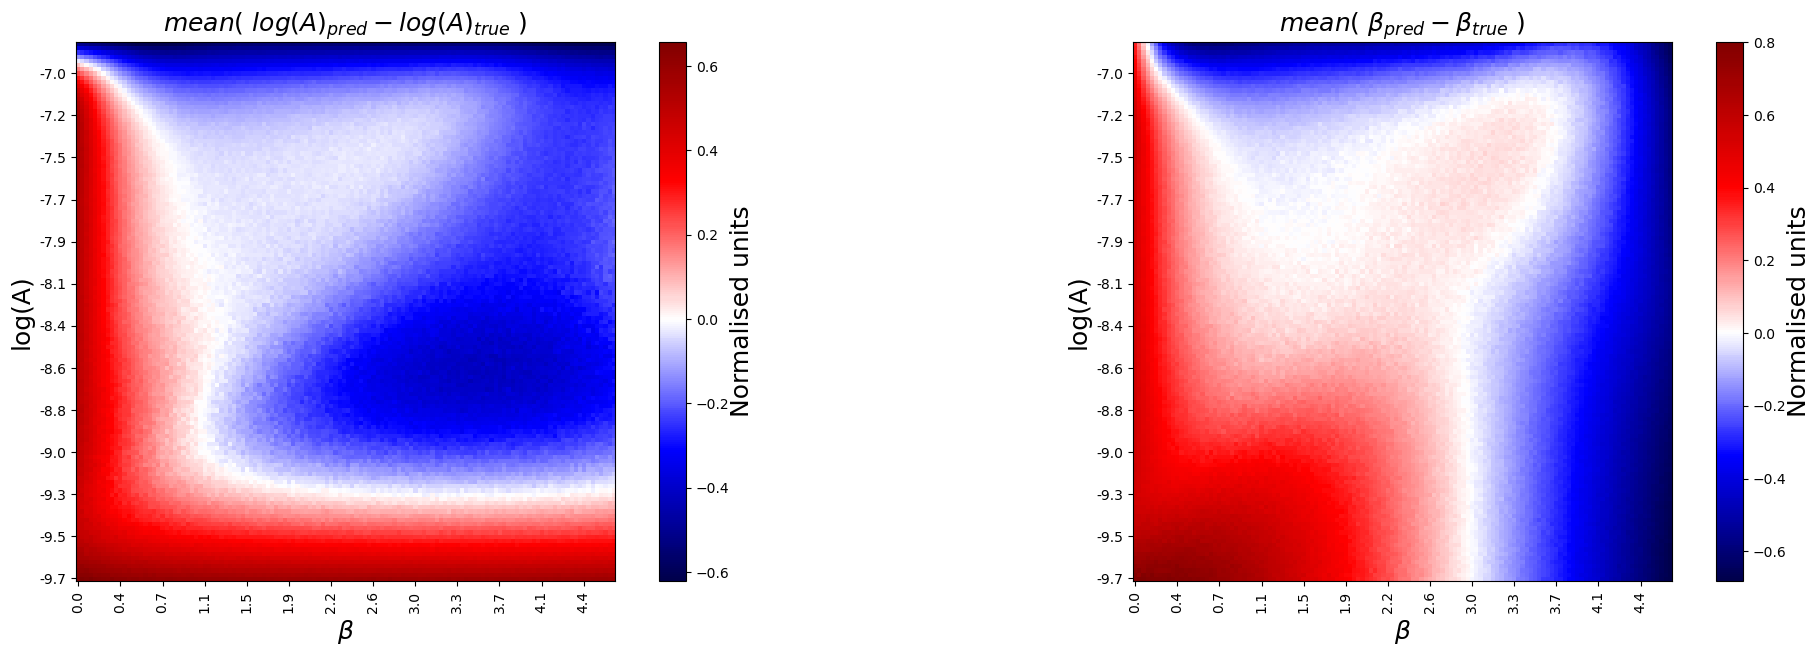

In [70]:
fig,ax=plt.subplots(1,2,figsize=(25,7))

img_arr=[]

img_arr+=[ax[0].imshow(mean_bias[:,:,0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
img_arr+=[ax[1].imshow(mean_bias[:,:,1],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=[r'$mean( \ log(A)_{pred}-log(A)_{true} \ )$',r'$mean( \ \beta_{pred}-\beta_{true} \ )$']
units=['Normalised units','Normalised units']

for i in range(2):
    
    
    ax[i].invert_yaxis()
    ax[i].set_yticks(np.arange(0,len(logA_array),10))
    ax[i].set_yticklabels(logA_array[::10].round(1))
    
    ax[i].set_xticks(np.arange(0,len(Beta_array),10))
    ax[i].set_xticklabels(Beta_array[::10].round(1),rotation=90)
    
    ax[i].set_ylabel('log(A)',fontsize=FS)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    ax[i].set_title(titles[i],fontsize=FS)
    
    cbar=plt.colorbar(img_arr[i],ax=ax[i])
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=0)

Сделать квадрат с contourf, где будет на верхнем ряду bias, а на нижнем- uncertainty. Затем сделать отдельную картинку где показать unbiased region и стрелки.

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_14236/2198496230.py:27: UserWarning: The following kwargs were not used by contour: 'label'
  img_arr+=[ax[0].contourf(X,Y,np.sqrt(I**2+J**2),10,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]


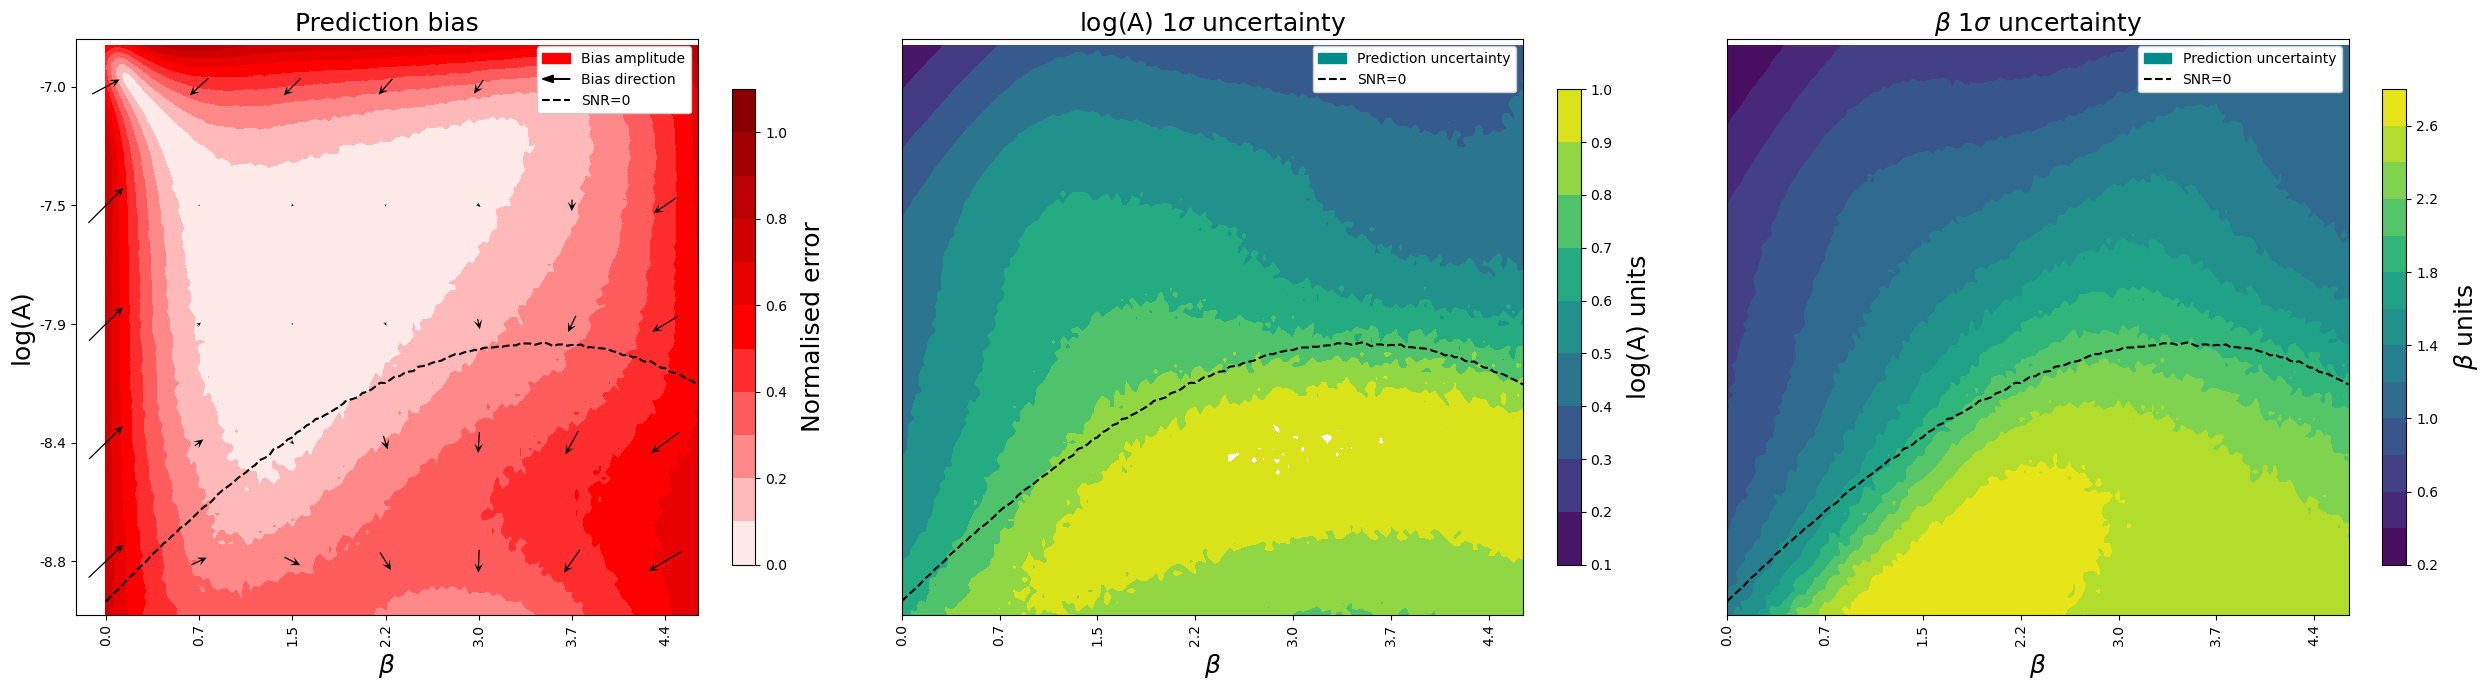

In [19]:
fig,ax=plt.subplots(1,3,figsize=(25,7))

#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

X,Y=np.meshgrid(np.arange(len(Beta_array)),np.arange(len(logA_array)))
I=mean_bias[:,:,1]
J=mean_bias[:,:,0]




def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(width, 0.5*height, -width, 0, length_includes_head=True, head_width=0.75*height )
    return p

ax[0].legend([red_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
           handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='upper right',framealpha=1,facecolor='w')

#Bias amplitude
img_arr=[]
#img_arr+=[ax[0].imshow(np.sqrt(I**2+J**2),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]
img_arr+=[ax[0].contourf(X,Y,np.sqrt(I**2+J**2),10,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]


#Quiver
step=20
imgquiver=ax[0].quiver(X[::step,::step],Y[::step,::step],I[::step,::step], J[::step,::step],scale=10,width=0.002,headwidth=7,headlength=7.5,pivot='middle',label='Bias direction')

#SNR contour
imgSNR=ax[0].contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')

red_patch = mpatches.Patch(color='red', label='The red data')
imgarr=ax[0].arrow(0,0,0,0,color='k',alpha=1)


sigma=1
mean_uncert=uncertainty_width.mean(axis=2)

#img_arr+=[ax[1].imshow(mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]))]
img_arr+=[ax[1].contourf(X,Y,mean_uncert[:,:,0,sigma-1]*(logA_array[1]-logA_array[0]),levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.])]
#img_arr+=[ax[2].imshow(mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]))]
img_arr+=[ax[2].contourf(X,Y,mean_uncert[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0]),levels=[0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8])]

titles=['Prediction bias','log(A) '+str(sigma)+r'$\sigma$'+' uncertainty',r'$\beta$ '+str(sigma)+r'$\sigma$'+' uncertainty']
units=['Normalised error','log(A) units',r'$\beta$'+' units']


for i in range(3):

    ax[i].invert_yaxis()

    labelstep=20
    if i==0:
        ax[i].set_yticks(np.arange(0,len(logA_array),labelstep))
        ax[i].set_yticklabels(logA_array[::labelstep].round(1))
        ax[i].set_ylabel('log(A)',fontsize=FS)
        ax[i].legend([red_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
           handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='upper right',framealpha=1,facecolor='w')
    else:
        ax[i].set_yticks([])
        imgSNR=ax[i].contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')
        blue_patch = mpatches.Patch(color='darkcyan', label='The blue data')
        ax[i].legend([blue_patch,imgSNR.collections[0]], ['Prediction uncertainty','SNR=0'],loc='upper right',framealpha=1,facecolor='w')
        #l=ax[i].legend(loc='upper right',framealpha=1,facecolor='w')
    
    ax[i].set_xticks(np.arange(0,len(Beta_array),labelstep))
    ax[i].set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)


    ax[i].set_title(titles[i],fontsize=FS)
    cbar=plt.colorbar(img_arr[i],ax=ax[i],fraction=0.035)
    cbar.ax.set_ylabel(units[i],rotation=90,fontsize=FS,labelpad=10)
    
    ax[i].set_ylim(np.argmin(np.abs(logA_array-(-9))),128)

fig.tight_layout(w_pad=5)

I can just label the levels and get rid of the colorbars. It will probably be easier to perceive